In [1]:
import torch.nn.utils.rnn as rnn
from torch.autograd import Variable

In [2]:
import torchnet as tnt

In [3]:
%matplotlib notebook
import os

# import torch.multiprocessing as multiprocessing

# multiprocessing.set_start_method('spawn')
import cv2
import numpy as np
# import matplotlib
# matplotlib.use('Agg')
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from IPython.display import display
from PIL import Image
import matplotlib.pyplot as plt
import sys
sys.path.insert(0, '../vae/')
from VAE import VAE
from tqdm import tnrange, tqdm_notebook
import torch
import torch.nn as nn

# Clustered classes and their inverse mappings

In [4]:
clustered_classes = []
mapping_classes_index = dict()
clustered_classes_count = []
file_name = 'class_clusters.txt'
with open(file_name, 'rt') as file:
    lines = file.read().splitlines()
    idx = -1
    for line in lines:
        words = line.split('\t')
        if not line.startswith('\t'):
            clustered_classes.append(set())
            clustered_classes_count.append(0)
            idx += 1
        class_name = line.strip().split('\t')[0]
        mapping_classes_index[class_name] = idx
        clustered_classes_count[idx] += int(line.strip().split('\t')[-1])
        clustered_classes[idx].add(class_name)

In [5]:
from pprint import pprint
class_with_count = list(zip(clustered_classes, clustered_classes_count))
class_with_count.sort(key=lambda x: x[1], reverse=True)

In [6]:
from math import ceil
filtered_classes = [x[0] for i,x in enumerate(class_with_count) if x[1]>500]
filtered_classes_count = [x[1] for i,x in enumerate(class_with_count) if x[1]>500]
mapping_filtered_classes = dict()
for i,classes in enumerate(filtered_classes):
    for c in classes:
        mapping_filtered_classes[c] = i

clustered_classes = filtered_classes
clustered_classes_count = filtered_classes_count

mapping_classes_index = mapping_filtered_classes

NUM_CLASSES = len(clustered_classes)
NUM_BYTES_FOR_MASK = NUM_CLASSES+1
print(NUM_CLASSES, NUM_BYTES_FOR_MASK)

24 25


In [7]:
print('\n'.join([', '.join(x)+': '+str(y) for x,y in zip(clustered_classes, clustered_classes_count)]))

Person, Woman, Boy, Man, Human body, Girl: 44429
Face, Hand, Hair, Ear, Arm, Head, Eye, Mouth, Leg, Beard, Nose: 24164
Trousers, Coat, Skirt, Tie, Shorts, Brassiere, Suit, Clothing, Jacket, Shirt, Jeans, Dress: 18591
Bicycle wheel, Car, Truck, Taxi, Bike, Tire, Wheel, Tank, Van, Licence plate, Bus, Auto part, Train, Land vehicle, Motorcycle, Vehicle: 13831
Beer, Cocktail, Wine glass, Bottle, Tin can, Wine, Juice, Drink, Coffee: 8164
Tomato, Pastry, Ice cream, Pumpkin, Food, Baked goods, Pizza, Snack, Seafood, Salad, Bread, Dairy, Mushroom, Squash, Cake, Vegetable, Fast food, Muffin, Dessert, Fruit, Sandwich, Strawberry: 4988
Footwear, Boot, Sandal, High heels: 4774
Deer, Horse, Dog, Turtle, Monkey, Sheep, Animal, Carnivore, Cat, Tortoise, Mammal, Squirrel, Lizard, Cattle, Reptile, Bear, Lion, Frog, Elephant: 3137
Computer monitor, Computer keyboard, Laptop, Camera, Television, Mobile phone: 3056
Picture frame, Kitchen & dining room table, Tap, Home appliance, Desk, Cabinetry, Table, Cu

In [8]:
import torch.utils.data as DD

class Dataset(DD.Dataset):
    # subset can be: 'train', 'val', 'test'
    def __init__(self, start, end, folder_path, td_output_dir, od_output_dir, max_length=0):
        super(Dataset, self).__init__()
        self.start = start
        self.end = end
        self.folder_path = folder_path
        self.od_output_dir = od_output_dir
        self.td_output_dir = td_output_dir
        self.files = []
        self.seq_lengths = []
        self.max_length = max_length
        self.resized_images()
        self.totalFiles = len(self.files)

    def __getitem__(self, index):
        return self.files[index]

    def __len__(self):
        return self.totalFiles
    
    def get_images_and_masks(self, i):
#         print('Reading:', i)
        path = os.path.join(self.folder_path, str(i))
        file_names = os.listdir(path)
        
        for idx, file_name in enumerate(tqdm_notebook(file_names[:100],desc='Read:'+str(i))):
            name = os.path.basename(file_name).split('.')[0]
            td_output_file = os.path.join(self.td_output_dir, str(i), name)+'.txt'
            od_output_file = os.path.join(self.od_output_dir, str(i), name)+'.txt'
            if file_name.endswith('.jpg') and (os.path.isfile(td_output_file) 
                                               or os.path.isfile(od_output_file)):
#                 print(file_name)
                orig_img = Image.open(os.path.join(path, file_name))
                img_masks = []#torch.zeros((900,5)).type(torch.FloatTensor)
                index = 0
                if os.path.isfile(td_output_file):
                    with open(td_output_file, 'rt') as file:
                        lines = file.read().splitlines()
                        for line in lines:
#                             print(line.split(','))
                            coord = [int(x) for x in line.split(',')]
                            img_width, img_height = 100,100
                            l = round(coord[0]*img_width/orig_img.size[0],0)/100.
                            r = round(coord[2]*img_width/orig_img.size[0],0)/100.
                            t = round(coord[1]*img_height/orig_img.size[1],0)/100.
                            b = round(coord[-1]*img_height/orig_img.size[1],0)/100.
#                             masks[idx,t:b,l:r,0] = 1
                            one_hot_class = [0]*NUM_BYTES_FOR_MASK
                            one_hot_class[0] = 1
                            img_masks.append(torch.FloatTensor(one_hot_class+[l,r,t,b]))
                            index+=1
                            
                if os.path.isfile(od_output_file):       
                    with open(od_output_file, 'rt') as file:
                        lines = file.read().splitlines()
                        for line in lines:
                            try:
                                class_idx = mapping_classes_index[
                                    line.split(':')[0].split(',')[-1]]+1
                                coord = line.split(':')[1].split(',')
                                coord = [round(float(x)*100,0) for j,x in enumerate(coord)]
                                t,b,l,r = coord[0]/100.,coord[2]/100.,coord[1]/100.,coord[3]/100.
#                                 masks[idx,coord[0]:coord[2],coord[1]:coord[3],
#                                       class_idx] = 1
                                one_hot_class = [0]*NUM_BYTES_FOR_MASK
                                one_hot_class[class_idx] = 1
                                img_masks.append(torch.FloatTensor(one_hot_class+[l,r,t,b]))
                                index+=1
                            except KeyError:
                                pass
                if len(img_masks)>0:
                    self.files.append(torch.stack(img_masks,0))
                    self.seq_lengths.append(len(img_masks))
                    self.max_length = max(len(img_masks), self.max_length)
#         return masks
        
    def resized_images(self):
        for i in tqdm_notebook(range(self.start, self.end), desc='1st loop'):
            self.get_images_and_masks(i)

def collate_fn(data):
    """Creates mini-batch tensors from the list of tuples (src_seq, trg_seq).
    We should build a custom collate_fn rather than using default collate_fn,
    because merging sequences (including padding) is not supported in default.
    Seqeuences are padded to the maximum length of mini-batch sequences (dynamic padding).
    Args:
        data: list of tuple (src_seq, trg_seq).
            - src_seq: torch tensor of shape (?); variable length.
            - trg_seq: torch tensor of shape (?); variable length.
    Returns:
        src_seqs: torch tensor of shape (batch_size, padded_length).
        src_lengths: list of length (batch_size); valid length for each padded source sequence.
        trg_seqs: torch tensor of shape (batch_size, padded_length).
        trg_lengths: list of length (batch_size); valid length for each padded target sequence.
    """
    def merge(sequences):
        lengths = [len(seq) for seq in sequences]
        padded_seqs = torch.zeros(len(sequences), max(lengths), NUM_BYTES_FOR_MASK+4).float()
        for i, seq in enumerate(sequences):
            end = lengths[i]
            padded_seqs[i, :end] = seq[:end]
        return padded_seqs, lengths

    # sort a list by sequence length (descending order) to use pack_padded_sequence
    data.sort(key=lambda x: len(x), reverse=True)

    # seperate source and target sequences
    src_seqs = data

    # merge sequences (from tuple of 1D tensor to 2D tensor)
    src_seqs, src_lengths = merge(src_seqs)

    return src_seqs, src_lengths

In [9]:
IMAGES_PATH = '/gpfs/scratch/asamanta/dataset/train_images/'
TEXT_DET_OUTPUT = '../../../td-output/'
OBJECT_DET_OUTPUT = '../../../od-output/'
OUT_TF_DATA = '/gpfs/scratch/asamanta/'

trSet = Dataset(0, 1, IMAGES_PATH, TEXT_DET_OUTPUT, OBJECT_DET_OUTPUT)
tstSet = Dataset(1, 2, IMAGES_PATH, TEXT_DET_OUTPUT, OBJECT_DET_OUTPUT, max_length=trSet.max_length)

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

In [10]:
from torch.utils.data import DataLoader
train_loader = DataLoader(trSet, batch_size=16,
                        shuffle=True, num_workers=4, collate_fn=collate_fn)
test_loader = DataLoader(tstSet, batch_size=16,
                        shuffle=True, num_workers=4, collate_fn=collate_fn)

In [11]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, isCuda):
        super(EncoderRNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.isCuda = isCuda
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, hidden_size)
        self.relu = nn.ReLU()
        
        #initialize weights
        nn.init.xavier_uniform(self.lstm.weight_ih_l0, gain=np.sqrt(2))
        nn.init.xavier_uniform(self.lstm.weight_hh_l0, gain=np.sqrt(2))

    def forward(self, input, lengths):
        tt = torch.cuda if self.isCuda else torch
        h0 = Variable(tt.FloatTensor(self.num_layers, input.size(0), self.hidden_size))
        c0 = Variable(tt.FloatTensor(self.num_layers, input.size(0), self.hidden_size))
        input = rnn.pack_padded_sequence(input, lengths=lengths, batch_first=True)
        encoded_input, hidden = self.lstm(input, (h0, c0))
        encoded_input, _ = rnn.pad_packed_sequence(encoded_input, batch_first=True)
        print(encoded_input)
        encoded_input = self.linear(encoded_input)
        encoded_input = self.relu(encoded_input)
        print(encoded_input)
        return encoded_input

class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, num_layers, isCuda):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.num_layers = num_layers
        
        self.isCuda = isCuda
        self.lstm = nn.LSTM(hidden_size, output_size, num_layers, batch_first=True)
        self.linear = nn.Linear(output_size, output_size)
        self.sigmoid = nn.Sigmoid()
        
        #initialize weights
        nn.init.xavier_uniform(self.lstm.weight_ih_l0, gain=np.sqrt(2))
        nn.init.xavier_uniform(self.lstm.weight_hh_l0, gain=np.sqrt(2))
        
    def forward(self, encoded_input):
        tt = torch.cuda if self.isCuda else torch
        h0 = Variable(tt.FloatTensor(self.num_layers, encoded_input.size(0), self.output_size))
        c0 = Variable(tt.FloatTensor(self.num_layers, encoded_input.size(0), self.output_size))
        decoded_output, hidden = self.lstm(encoded_input, (h0, c0))
        decoded_output = self.linear(decoded_output)
        decoded_output = self.sigmoid(decoded_output)
        return decoded_output

class LSTMAE(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, isCuda):
        super(LSTMAE, self).__init__()
        self.encoder = EncoderRNN(input_size, hidden_size, num_layers, isCuda)
        self.decoder = DecoderRNN(hidden_size, input_size, num_layers, isCuda)
        
    def forward(self, input, lengths):
#         print(input.size())
        encoded_input = self.encoder(input, lengths)
        decoded_output = self.decoder(encoded_input)
        return decoded_output

In [12]:
model = LSTMAE(input_size=NUM_BYTES_FOR_MASK+4, hidden_size=8, num_layers=2, isCuda=False)

In [13]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, betas=[0.6, 0.9])
criterion = nn.MSELoss().type(torch.FloatTensor)

In [14]:
def run_epoch(data_loader, model, criterion, epoch, is_training, optimizer=None):
    if is_training:
        model.train()
        logger_prefix = 'train'
    else:
        model.eval()
        logger_prefix = 'val'
    meter_loss = tnt.meter.AverageValueMeter()

    for batch_idx, sample in enumerate(train_loader):
        input_sequence_var = Variable(sample[0])#.type(torch.cuda.FloatTensor)

        output_logits = model(input_sequence_var, sample[1])
        if not is_training:
            print(output_logits[0][0], input_sequence_var[0][0])
        loss = criterion(output_logits, input_sequence_var)

        if is_training:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        meter_loss.add(loss.data[0])
        break
    print('%s Epoch: %d  , Loss: %.4f'%(logger_prefix, epoch, meter_loss.value()[0]))
#     return acc.value()[0]

In [15]:
num_epochs = 100
evaluate_every_epoch = 10
try:
    for e in range(num_epochs):
        run_epoch(train_loader, model, criterion, e, True, optimizer)
        if (e+1) % evaluate_every_epoch == 0:
            run_epoch(test_loader, model, criterion, e, False, None)   
except KeyboardInterrupt:
    print('Stopped')

Variable containing:
(0 ,.,.) = 
 -0.0000  0.0000 -0.0000  ...  -0.0000  0.0000  0.0000
 -0.1144  0.0781 -0.2510  ...  -0.0921  0.5279  0.1696
 -0.0016  0.0806  0.0304  ...  -0.1265  0.5510  0.0939
           ...             ⋱             ...          
  0.0612  0.0197  0.3012  ...  -0.1721  0.1825  0.0520
  0.0701  0.0255  0.3022  ...  -0.1500  0.1252  0.0486
  0.0763  0.0323  0.3046  ...  -0.1414  0.0933  0.0446

(1 ,.,.) = 
 -0.0000  0.0000 -0.0000  ...   0.0000 -0.0000  0.0000
 -0.1123  0.0872 -0.2069  ...  -0.0769 -0.2963  0.2011
  0.0214  0.1168  0.0750  ...  -0.0718 -0.1041  0.0778
           ...             ⋱             ...          
  0.0000  0.0000  0.0000  ...   0.0000  0.0000  0.0000
  0.0000  0.0000  0.0000  ...   0.0000  0.0000  0.0000
  0.0000  0.0000  0.0000  ...   0.0000  0.0000  0.0000

(2 ,.,.) = 
 -0.0000 -0.7616  0.0000  ...  -0.7616  0.0000 -0.0000
 -0.1551 -0.1142  0.0792  ...  -0.1639  0.5074 -0.2036
  0.0059  0.0072  0.1651  ...  -0.1746  0.5018 -0.0664
      

train Epoch: 1  , Loss: 0.2395
Variable containing:
(0 ,.,.) = 
 nan nan nan  ...  nan nan nan
 nan nan nan  ...  nan nan nan
 nan nan nan  ...  nan nan nan
     ...       ⋱       ...    
 nan nan nan  ...  nan nan nan
 nan nan nan  ...  nan nan nan
 nan nan nan  ...  nan nan nan

(1 ,.,.) = 
 nan nan nan  ...  nan nan nan
 nan nan nan  ...  nan nan nan
 nan nan nan  ...  nan nan nan
     ...       ⋱       ...    
   0   0   0  ...    0   0   0
   0   0   0  ...    0   0   0
   0   0   0  ...    0   0   0

(2 ,.,.) = 
 nan nan nan  ...  nan nan nan
 nan nan nan  ...  nan nan nan
 nan nan nan  ...  nan nan nan
     ...       ⋱       ...    
   0   0   0  ...    0   0   0
   0   0   0  ...    0   0   0
   0   0   0  ...    0   0   0
...

(13,.,.) = 
 nan nan nan  ...  nan nan nan
 nan nan nan  ...  nan nan nan
 nan nan nan  ...  nan nan nan
     ...       ⋱       ...    
   0   0   0  ...    0   0   0
   0   0   0  ...    0   0   0
   0   0   0  ...    0   0   0

(14,.,.) = 
 nan nan nan

Variable containing:
( 0 ,.,.) = 
 nan nan nan  ...  nan nan nan
 nan nan nan  ...  nan nan nan
 nan nan nan  ...  nan nan nan
     ...       ⋱       ...    
 nan nan nan  ...  nan nan nan
 nan nan nan  ...  nan nan nan
 nan nan nan  ...  nan nan nan

( 1 ,.,.) = 
 nan nan nan  ...  nan nan nan
 nan nan nan  ...  nan nan nan
 nan nan nan  ...  nan nan nan
     ...       ⋱       ...    
   0   0   0  ...    0   0   0
   0   0   0  ...    0   0   0
   0   0   0  ...    0   0   0

( 2 ,.,.) = 
 nan nan nan  ...  nan nan nan
 nan nan nan  ...  nan nan nan
 nan nan nan  ...  nan nan nan
     ...       ⋱       ...    
   0   0   0  ...    0   0   0
   0   0   0  ...    0   0   0
   0   0   0  ...    0   0   0
... 

(13 ,.,.) = 
 nan nan nan  ...  nan nan nan
 nan nan nan  ...  nan nan nan
 nan nan nan  ...  nan nan nan
     ...       ⋱       ...    
   0   0   0  ...    0   0   0
   0   0   0  ...    0   0   0
   0   0   0  ...    0   0   0

(14 ,.,.) = 
 nan nan nan  ...  nan nan nan
 nan n

train Epoch: 7  , Loss: nan
Variable containing:
( 0 ,.,.) = 
 nan nan nan  ...  nan nan nan
 nan nan nan  ...  nan nan nan
 nan nan nan  ...  nan nan nan
     ...       ⋱       ...    
 nan nan nan  ...  nan nan nan
 nan nan nan  ...  nan nan nan
 nan nan nan  ...  nan nan nan

( 1 ,.,.) = 
 nan nan nan  ...  nan nan nan
 nan nan nan  ...  nan nan nan
 nan nan nan  ...  nan nan nan
     ...       ⋱       ...    
   0   0   0  ...    0   0   0
   0   0   0  ...    0   0   0
   0   0   0  ...    0   0   0

( 2 ,.,.) = 
 nan nan nan  ...  nan nan nan
 nan nan nan  ...  nan nan nan
 nan nan nan  ...  nan nan nan
     ...       ⋱       ...    
   0   0   0  ...    0   0   0
   0   0   0  ...    0   0   0
   0   0   0  ...    0   0   0
... 

(13 ,.,.) = 
 nan nan nan  ...  nan nan nan
 nan nan nan  ...  nan nan nan
 nan nan nan  ...  nan nan nan
     ...       ⋱       ...    
   0   0   0  ...    0   0   0
   0   0   0  ...    0   0   0
   0   0   0  ...    0   0   0

(14 ,.,.) = 
 nan nan 

Variable containing:
( 0 ,.,.) = 
 nan nan nan  ...  nan nan nan
 nan nan nan  ...  nan nan nan
 nan nan nan  ...  nan nan nan
     ...       ⋱       ...    
 nan nan nan  ...  nan nan nan
 nan nan nan  ...  nan nan nan
 nan nan nan  ...  nan nan nan

( 1 ,.,.) = 
 nan nan nan  ...  nan nan nan
 nan nan nan  ...  nan nan nan
 nan nan nan  ...  nan nan nan
     ...       ⋱       ...    
   0   0   0  ...    0   0   0
   0   0   0  ...    0   0   0
   0   0   0  ...    0   0   0

( 2 ,.,.) = 
 nan nan nan  ...  nan nan nan
 nan nan nan  ...  nan nan nan
 nan nan nan  ...  nan nan nan
     ...       ⋱       ...    
   0   0   0  ...    0   0   0
   0   0   0  ...    0   0   0
   0   0   0  ...    0   0   0
... 

(13 ,.,.) = 
 nan nan nan  ...  nan nan nan
 nan nan nan  ...  nan nan nan
 nan nan nan  ...  nan nan nan
     ...       ⋱       ...    
   0   0   0  ...    0   0   0
   0   0   0  ...    0   0   0
   0   0   0  ...    0   0   0

(14 ,.,.) = 
 nan nan nan  ...  nan nan nan
 nan n

train Epoch: 12  , Loss: nan
Variable containing:
( 0 ,.,.) = 
 nan nan nan  ...  nan nan nan
 nan nan nan  ...  nan nan nan
 nan nan nan  ...  nan nan nan
     ...       ⋱       ...    
 nan nan nan  ...  nan nan nan
 nan nan nan  ...  nan nan nan
 nan nan nan  ...  nan nan nan

( 1 ,.,.) = 
 nan nan nan  ...  nan nan nan
 nan nan nan  ...  nan nan nan
 nan nan nan  ...  nan nan nan
     ...       ⋱       ...    
   0   0   0  ...    0   0   0
   0   0   0  ...    0   0   0
   0   0   0  ...    0   0   0

( 2 ,.,.) = 
 nan nan nan  ...  nan nan nan
 nan nan nan  ...  nan nan nan
 nan nan nan  ...  nan nan nan
     ...       ⋱       ...    
   0   0   0  ...    0   0   0
   0   0   0  ...    0   0   0
   0   0   0  ...    0   0   0
... 

(13 ,.,.) = 
 nan nan nan  ...  nan nan nan
 nan nan nan  ...  nan nan nan
 nan nan nan  ...  nan nan nan
     ...       ⋱       ...    
   0   0   0  ...    0   0   0
   0   0   0  ...    0   0   0
   0   0   0  ...    0   0   0

(14 ,.,.) = 
 nan nan

train Epoch: 15  , Loss: nan
Variable containing:
(0 ,.,.) = 
 nan nan nan  ...  nan nan nan
 nan nan nan  ...  nan nan nan
 nan nan nan  ...  nan nan nan
     ...       ⋱       ...    
 nan nan nan  ...  nan nan nan
 nan nan nan  ...  nan nan nan
 nan nan nan  ...  nan nan nan

(1 ,.,.) = 
 nan nan nan  ...  nan nan nan
 nan nan nan  ...  nan nan nan
 nan nan nan  ...  nan nan nan
     ...       ⋱       ...    
   0   0   0  ...    0   0   0
   0   0   0  ...    0   0   0
   0   0   0  ...    0   0   0

(2 ,.,.) = 
 nan nan nan  ...  nan nan nan
 nan nan nan  ...  nan nan nan
 nan nan nan  ...  nan nan nan
     ...       ⋱       ...    
   0   0   0  ...    0   0   0
   0   0   0  ...    0   0   0
   0   0   0  ...    0   0   0
...

(13,.,.) = 
 nan nan nan  ...  nan nan nan
 nan nan nan  ...  nan nan nan
 nan nan nan  ...  nan nan nan
     ...       ⋱       ...    
   0   0   0  ...    0   0   0
   0   0   0  ...    0   0   0
   0   0   0  ...    0   0   0

(14,.,.) = 
 nan nan nan  

Variable containing:
(0 ,.,.) = 
 nan nan nan  ...  nan nan nan
 nan nan nan  ...  nan nan nan
 nan nan nan  ...  nan nan nan
     ...       ⋱       ...    
 nan nan nan  ...  nan nan nan
 nan nan nan  ...  nan nan nan
 nan nan nan  ...  nan nan nan

(1 ,.,.) = 
 nan nan nan  ...  nan nan nan
 nan nan nan  ...  nan nan nan
 nan nan nan  ...  nan nan nan
     ...       ⋱       ...    
 nan nan nan  ...  nan nan nan
 nan nan nan  ...  nan nan nan
   0   0   0  ...    0   0   0

(2 ,.,.) = 
 nan nan nan  ...  nan nan nan
 nan nan nan  ...  nan nan nan
 nan nan nan  ...  nan nan nan
     ...       ⋱       ...    
 nan nan nan  ...  nan nan nan
 nan nan nan  ...  nan nan nan
   0   0   0  ...    0   0   0
...

(13,.,.) = 
 nan nan nan  ...  nan nan nan
 nan nan nan  ...  nan nan nan
 nan nan nan  ...  nan nan nan
     ...       ⋱       ...    
   0   0   0  ...    0   0   0
   0   0   0  ...    0   0   0
   0   0   0  ...    0   0   0

(14,.,.) = 
 nan nan nan  ...  nan nan nan
 nan nan nan

train Epoch: 20  , Loss: nan
Variable containing:
(0 ,.,.) = 
 nan nan nan  ...  nan nan nan
 nan nan nan  ...  nan nan nan
 nan nan nan  ...  nan nan nan
     ...       ⋱       ...    
 nan nan nan  ...  nan nan nan
 nan nan nan  ...  nan nan nan
 nan nan nan  ...  nan nan nan

(1 ,.,.) = 
 nan nan nan  ...  nan nan nan
 nan nan nan  ...  nan nan nan
 nan nan nan  ...  nan nan nan
     ...       ⋱       ...    
   0   0   0  ...    0   0   0
   0   0   0  ...    0   0   0
   0   0   0  ...    0   0   0

(2 ,.,.) = 
 nan nan nan  ...  nan nan nan
 nan nan nan  ...  nan nan nan
 nan nan nan  ...  nan nan nan
     ...       ⋱       ...    
   0   0   0  ...    0   0   0
   0   0   0  ...    0   0   0
   0   0   0  ...    0   0   0
...

(13,.,.) = 
 nan nan nan  ...  nan nan nan
 nan nan nan  ...  nan nan nan
 nan nan nan  ...  nan nan nan
     ...       ⋱       ...    
   0   0   0  ...    0   0   0
   0   0   0  ...    0   0   0
   0   0   0  ...    0   0   0

(14,.,.) = 
 nan nan nan  

train Epoch: 23  , Loss: nan
Variable containing:
(0 ,.,.) = 
 nan nan nan  ...  nan nan nan
 nan nan nan  ...  nan nan nan
 nan nan nan  ...  nan nan nan
     ...       ⋱       ...    
 nan nan nan  ...  nan nan nan
 nan nan nan  ...  nan nan nan
 nan nan nan  ...  nan nan nan

(1 ,.,.) = 
 nan nan nan  ...  nan nan nan
 nan nan nan  ...  nan nan nan
 nan nan nan  ...  nan nan nan
     ...       ⋱       ...    
   0   0   0  ...    0   0   0
   0   0   0  ...    0   0   0
   0   0   0  ...    0   0   0

(2 ,.,.) = 
 nan nan nan  ...  nan nan nan
 nan nan nan  ...  nan nan nan
 nan nan nan  ...  nan nan nan
     ...       ⋱       ...    
   0   0   0  ...    0   0   0
   0   0   0  ...    0   0   0
   0   0   0  ...    0   0   0
...

(13,.,.) = 
 nan nan nan  ...  nan nan nan
 nan nan nan  ...  nan nan nan
 nan nan nan  ...  nan nan nan
     ...       ⋱       ...    
   0   0   0  ...    0   0   0
   0   0   0  ...    0   0   0
   0   0   0  ...    0   0   0

(14,.,.) = 
 nan nan nan  

train Epoch: 26  , Loss: nan
Variable containing:
(0 ,.,.) = 
 nan nan nan  ...  nan nan nan
 nan nan nan  ...  nan nan nan
 nan nan nan  ...  nan nan nan
     ...       ⋱       ...    
 nan nan nan  ...  nan nan nan
 nan nan nan  ...  nan nan nan
 nan nan nan  ...  nan nan nan

(1 ,.,.) = 
 nan nan nan  ...  nan nan nan
 nan nan nan  ...  nan nan nan
 nan nan nan  ...  nan nan nan
     ...       ⋱       ...    
 nan nan nan  ...  nan nan nan
 nan nan nan  ...  nan nan nan
   0   0   0  ...    0   0   0

(2 ,.,.) = 
 nan nan nan  ...  nan nan nan
 nan nan nan  ...  nan nan nan
 nan nan nan  ...  nan nan nan
     ...       ⋱       ...    
   0   0   0  ...    0   0   0
   0   0   0  ...    0   0   0
   0   0   0  ...    0   0   0
...

(13,.,.) = 
 nan nan nan  ...  nan nan nan
 nan nan nan  ...  nan nan nan
 nan nan nan  ...  nan nan nan
     ...       ⋱       ...    
   0   0   0  ...    0   0   0
   0   0   0  ...    0   0   0
   0   0   0  ...    0   0   0

(14,.,.) = 
 nan nan nan  

train Epoch: 29  , Loss: nan
Variable containing:
( 0 ,.,.) = 
 nan nan nan  ...  nan nan nan
 nan nan nan  ...  nan nan nan
 nan nan nan  ...  nan nan nan
     ...       ⋱       ...    
 nan nan nan  ...  nan nan nan
 nan nan nan  ...  nan nan nan
 nan nan nan  ...  nan nan nan

( 1 ,.,.) = 
 nan nan nan  ...  nan nan nan
 nan nan nan  ...  nan nan nan
 nan nan nan  ...  nan nan nan
     ...       ⋱       ...    
   0   0   0  ...    0   0   0
   0   0   0  ...    0   0   0
   0   0   0  ...    0   0   0

( 2 ,.,.) = 
 nan nan nan  ...  nan nan nan
 nan nan nan  ...  nan nan nan
 nan nan nan  ...  nan nan nan
     ...       ⋱       ...    
   0   0   0  ...    0   0   0
   0   0   0  ...    0   0   0
   0   0   0  ...    0   0   0
... 

(13 ,.,.) = 
 nan nan nan  ...  nan nan nan
 nan nan nan  ...  nan nan nan
 nan nan nan  ...  nan nan nan
     ...       ⋱       ...    
   0   0   0  ...    0   0   0
   0   0   0  ...    0   0   0
   0   0   0  ...    0   0   0

(14 ,.,.) = 
 nan nan

train Epoch: 31  , Loss: nan
Variable containing:
( 0 ,.,.) = 
 nan nan nan  ...  nan nan nan
 nan nan nan  ...  nan nan nan
 nan nan nan  ...  nan nan nan
     ...       ⋱       ...    
 nan nan nan  ...  nan nan nan
 nan nan nan  ...  nan nan nan
 nan nan nan  ...  nan nan nan

( 1 ,.,.) = 
 nan nan nan  ...  nan nan nan
 nan nan nan  ...  nan nan nan
 nan nan nan  ...  nan nan nan
     ...       ⋱       ...    
   0   0   0  ...    0   0   0
   0   0   0  ...    0   0   0
   0   0   0  ...    0   0   0

( 2 ,.,.) = 
 nan nan nan  ...  nan nan nan
 nan nan nan  ...  nan nan nan
 nan nan nan  ...  nan nan nan
     ...       ⋱       ...    
   0   0   0  ...    0   0   0
   0   0   0  ...    0   0   0
   0   0   0  ...    0   0   0
... 

(13 ,.,.) = 
 nan nan nan  ...  nan nan nan
 nan nan nan  ...  nan nan nan
 nan nan nan  ...  nan nan nan
     ...       ⋱       ...    
   0   0   0  ...    0   0   0
   0   0   0  ...    0   0   0
   0   0   0  ...    0   0   0

(14 ,.,.) = 
 nan nan

Variable containing:
(0 ,.,.) = 
 nan nan nan  ...  nan nan nan
 nan nan nan  ...  nan nan nan
 nan nan nan  ...  nan nan nan
     ...       ⋱       ...    
 nan nan nan  ...  nan nan nan
 nan nan nan  ...  nan nan nan
 nan nan nan  ...  nan nan nan

(1 ,.,.) = 
 nan nan nan  ...  nan nan nan
 nan nan nan  ...  nan nan nan
 nan nan nan  ...  nan nan nan
     ...       ⋱       ...    
   0   0   0  ...    0   0   0
   0   0   0  ...    0   0   0
   0   0   0  ...    0   0   0

(2 ,.,.) = 
 nan nan nan  ...  nan nan nan
 nan nan nan  ...  nan nan nan
 nan nan nan  ...  nan nan nan
     ...       ⋱       ...    
   0   0   0  ...    0   0   0
   0   0   0  ...    0   0   0
   0   0   0  ...    0   0   0
...

(13,.,.) = 
 nan nan nan  ...  nan nan nan
 nan nan nan  ...  nan nan nan
 nan nan nan  ...  nan nan nan
     ...       ⋱       ...    
   0   0   0  ...    0   0   0
   0   0   0  ...    0   0   0
   0   0   0  ...    0   0   0

(14,.,.) = 
 nan nan nan  ...  nan nan nan
 nan nan nan

train Epoch: 37  , Loss: nan
Variable containing:
(0 ,.,.) = 
 nan nan nan  ...  nan nan nan
 nan nan nan  ...  nan nan nan
 nan nan nan  ...  nan nan nan
     ...       ⋱       ...    
 nan nan nan  ...  nan nan nan
 nan nan nan  ...  nan nan nan
 nan nan nan  ...  nan nan nan

(1 ,.,.) = 
 nan nan nan  ...  nan nan nan
 nan nan nan  ...  nan nan nan
 nan nan nan  ...  nan nan nan
     ...       ⋱       ...    
   0   0   0  ...    0   0   0
   0   0   0  ...    0   0   0
   0   0   0  ...    0   0   0

(2 ,.,.) = 
 nan nan nan  ...  nan nan nan
 nan nan nan  ...  nan nan nan
 nan nan nan  ...  nan nan nan
     ...       ⋱       ...    
   0   0   0  ...    0   0   0
   0   0   0  ...    0   0   0
   0   0   0  ...    0   0   0
...

(13,.,.) = 
 nan nan nan  ...  nan nan nan
 nan nan nan  ...  nan nan nan
 nan nan nan  ...  nan nan nan
     ...       ⋱       ...    
   0   0   0  ...    0   0   0
   0   0   0  ...    0   0   0
   0   0   0  ...    0   0   0

(14,.,.) = 
 nan nan nan  

Variable containing:
( 0 ,.,.) = 
 nan nan nan  ...  nan nan nan
 nan nan nan  ...  nan nan nan
 nan nan nan  ...  nan nan nan
     ...       ⋱       ...    
 nan nan nan  ...  nan nan nan
 nan nan nan  ...  nan nan nan
 nan nan nan  ...  nan nan nan

( 1 ,.,.) = 
 nan nan nan  ...  nan nan nan
 nan nan nan  ...  nan nan nan
 nan nan nan  ...  nan nan nan
     ...       ⋱       ...    
   0   0   0  ...    0   0   0
   0   0   0  ...    0   0   0
   0   0   0  ...    0   0   0

( 2 ,.,.) = 
 nan nan nan  ...  nan nan nan
 nan nan nan  ...  nan nan nan
 nan nan nan  ...  nan nan nan
     ...       ⋱       ...    
   0   0   0  ...    0   0   0
   0   0   0  ...    0   0   0
   0   0   0  ...    0   0   0
... 

(13 ,.,.) = 
 nan nan nan  ...  nan nan nan
 nan nan nan  ...  nan nan nan
 nan nan nan  ...  nan nan nan
     ...       ⋱       ...    
   0   0   0  ...    0   0   0
   0   0   0  ...    0   0   0
   0   0   0  ...    0   0   0

(14 ,.,.) = 
 nan nan nan  ...  nan nan nan
 nan n

train Epoch: 42  , Loss: nan
Variable containing:
(0 ,.,.) = 
 nan nan nan  ...  nan nan nan
 nan nan nan  ...  nan nan nan
 nan nan nan  ...  nan nan nan
     ...       ⋱       ...    
 nan nan nan  ...  nan nan nan
 nan nan nan  ...  nan nan nan
 nan nan nan  ...  nan nan nan

(1 ,.,.) = 
 nan nan nan  ...  nan nan nan
 nan nan nan  ...  nan nan nan
 nan nan nan  ...  nan nan nan
     ...       ⋱       ...    
   0   0   0  ...    0   0   0
   0   0   0  ...    0   0   0
   0   0   0  ...    0   0   0

(2 ,.,.) = 
 nan nan nan  ...  nan nan nan
 nan nan nan  ...  nan nan nan
 nan nan nan  ...  nan nan nan
     ...       ⋱       ...    
   0   0   0  ...    0   0   0
   0   0   0  ...    0   0   0
   0   0   0  ...    0   0   0
...

(13,.,.) = 
 nan nan nan  ...  nan nan nan
 nan nan nan  ...  nan nan nan
 nan nan nan  ...  nan nan nan
     ...       ⋱       ...    
   0   0   0  ...    0   0   0
   0   0   0  ...    0   0   0
   0   0   0  ...    0   0   0

(14,.,.) = 
 nan nan nan  

train Epoch: 45  , Loss: nan
Variable containing:
(0 ,.,.) = 
 nan nan nan  ...  nan nan nan
 nan nan nan  ...  nan nan nan
 nan nan nan  ...  nan nan nan
     ...       ⋱       ...    
 nan nan nan  ...  nan nan nan
 nan nan nan  ...  nan nan nan
 nan nan nan  ...  nan nan nan

(1 ,.,.) = 
 nan nan nan  ...  nan nan nan
 nan nan nan  ...  nan nan nan
 nan nan nan  ...  nan nan nan
     ...       ⋱       ...    
   0   0   0  ...    0   0   0
   0   0   0  ...    0   0   0
   0   0   0  ...    0   0   0

(2 ,.,.) = 
 nan nan nan  ...  nan nan nan
 nan nan nan  ...  nan nan nan
 nan nan nan  ...  nan nan nan
     ...       ⋱       ...    
   0   0   0  ...    0   0   0
   0   0   0  ...    0   0   0
   0   0   0  ...    0   0   0
...

(13,.,.) = 
 nan nan nan  ...  nan nan nan
 nan nan nan  ...  nan nan nan
 nan nan nan  ...  nan nan nan
     ...       ⋱       ...    
   0   0   0  ...    0   0   0
   0   0   0  ...    0   0   0
   0   0   0  ...    0   0   0

(14,.,.) = 
 nan nan nan  

train Epoch: 48  , Loss: nan
Variable containing:
( 0 ,.,.) = 
 nan nan nan  ...  nan nan nan
 nan nan nan  ...  nan nan nan
 nan nan nan  ...  nan nan nan
     ...       ⋱       ...    
 nan nan nan  ...  nan nan nan
 nan nan nan  ...  nan nan nan
 nan nan nan  ...  nan nan nan

( 1 ,.,.) = 
 nan nan nan  ...  nan nan nan
 nan nan nan  ...  nan nan nan
 nan nan nan  ...  nan nan nan
     ...       ⋱       ...    
   0   0   0  ...    0   0   0
   0   0   0  ...    0   0   0
   0   0   0  ...    0   0   0

( 2 ,.,.) = 
 nan nan nan  ...  nan nan nan
 nan nan nan  ...  nan nan nan
 nan nan nan  ...  nan nan nan
     ...       ⋱       ...    
   0   0   0  ...    0   0   0
   0   0   0  ...    0   0   0
   0   0   0  ...    0   0   0
... 

(13 ,.,.) = 
 nan nan nan  ...  nan nan nan
 nan nan nan  ...  nan nan nan
 nan nan nan  ...  nan nan nan
     ...       ⋱       ...    
   0   0   0  ...    0   0   0
   0   0   0  ...    0   0   0
   0   0   0  ...    0   0   0

(14 ,.,.) = 
 nan nan

Variable containing:
( 0 ,.,.) = 
 nan nan nan  ...  nan nan nan
 nan nan nan  ...  nan nan nan
 nan nan nan  ...  nan nan nan
     ...       ⋱       ...    
 nan nan nan  ...  nan nan nan
 nan nan nan  ...  nan nan nan
 nan nan nan  ...  nan nan nan

( 1 ,.,.) = 
 nan nan nan  ...  nan nan nan
 nan nan nan  ...  nan nan nan
 nan nan nan  ...  nan nan nan
     ...       ⋱       ...    
   0   0   0  ...    0   0   0
   0   0   0  ...    0   0   0
   0   0   0  ...    0   0   0

( 2 ,.,.) = 
 nan nan nan  ...  nan nan nan
 nan nan nan  ...  nan nan nan
 nan nan nan  ...  nan nan nan
     ...       ⋱       ...    
   0   0   0  ...    0   0   0
   0   0   0  ...    0   0   0
   0   0   0  ...    0   0   0
... 

(13 ,.,.) = 
 nan nan nan  ...  nan nan nan
 nan nan nan  ...  nan nan nan
 nan nan nan  ...  nan nan nan
     ...       ⋱       ...    
   0   0   0  ...    0   0   0
   0   0   0  ...    0   0   0
   0   0   0  ...    0   0   0

(14 ,.,.) = 
 nan nan nan  ...  nan nan nan
 nan n

Process Process-231:
Process Process-230:
Process Process-229:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/gpfs/home/asamanta/.conda/envs/tf1.4/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/gpfs/home/asamanta/.conda/envs/tf1.4/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/gpfs/home/asamanta/.conda/envs/tf1.4/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/gpfs/home/asamanta/.conda/envs/tf1.4/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/gpfs/home/asamanta/.conda/envs/tf1.4/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/gpfs/home/asamanta/.conda/envs/tf1.4/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwa

# Retreive images from dataset

# Visualize one image and its masks

<IPython.core.display.Javascript object>


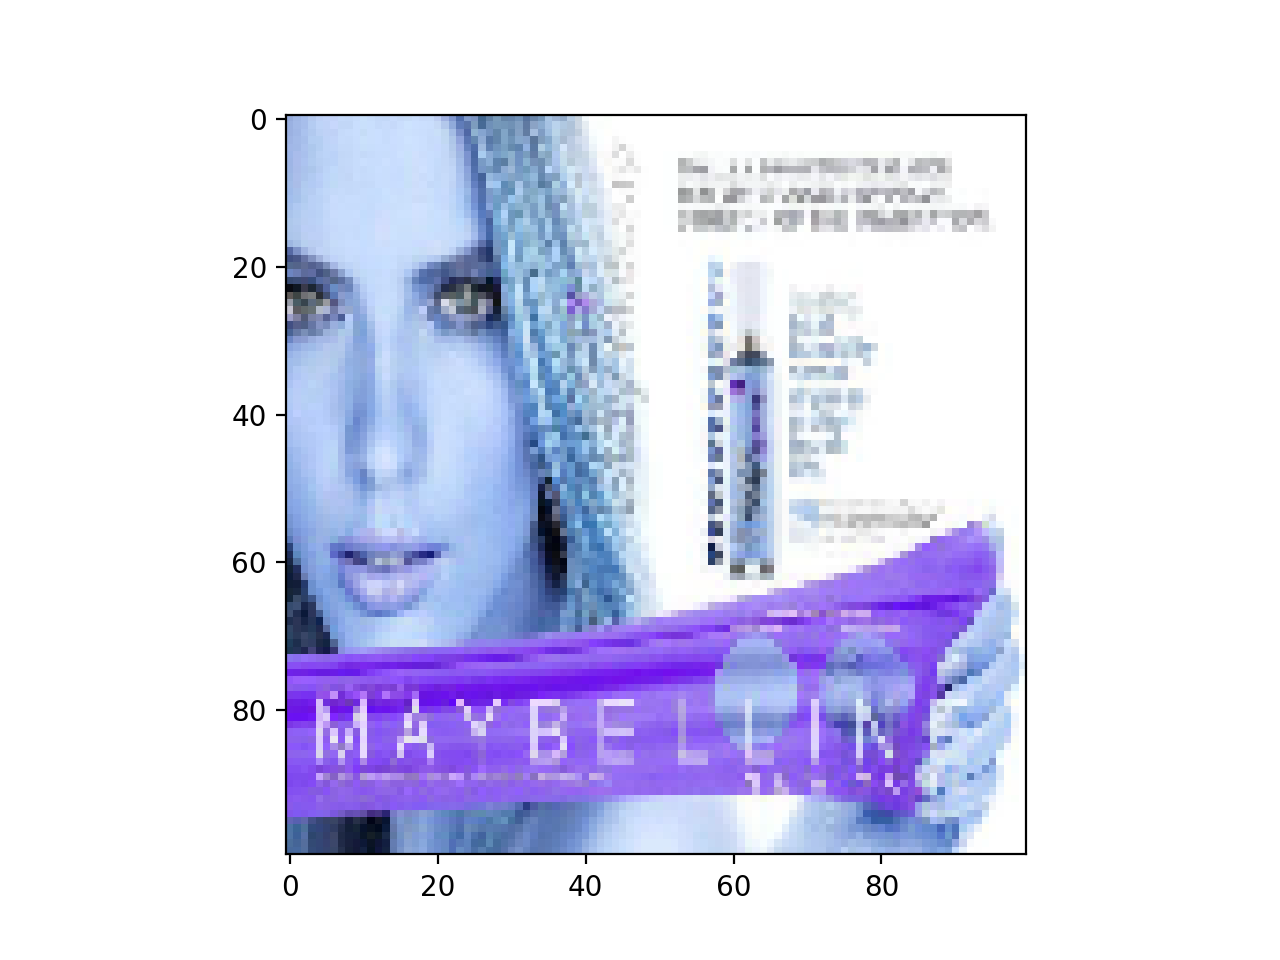

<IPython.core.display.Javascript object>


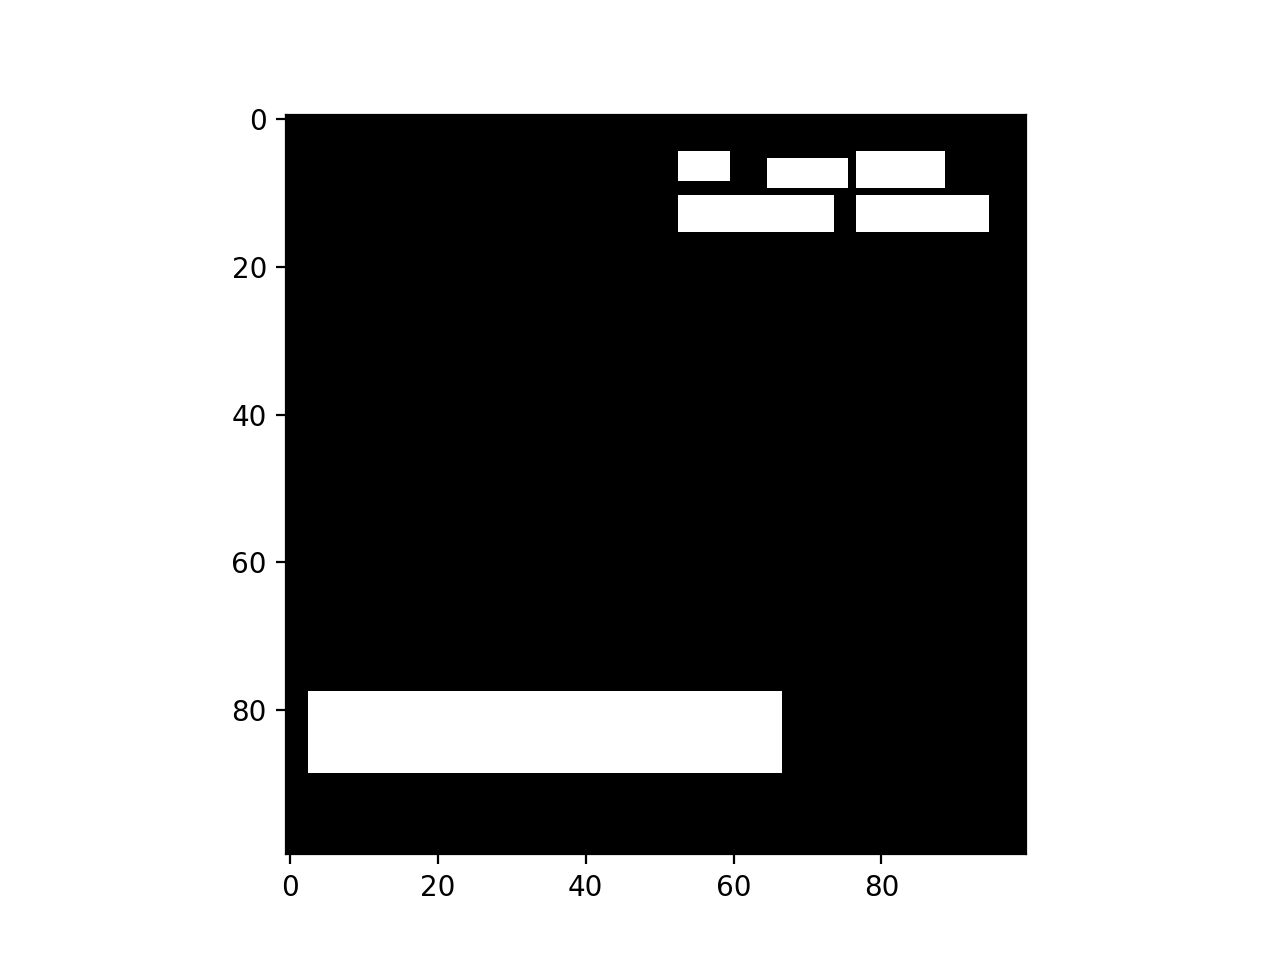

Layer: Text
Layer: {'Woman', 'Girl', 'Man', 'Person', 'Boy', 'Human body'}


<IPython.core.display.Javascript object>


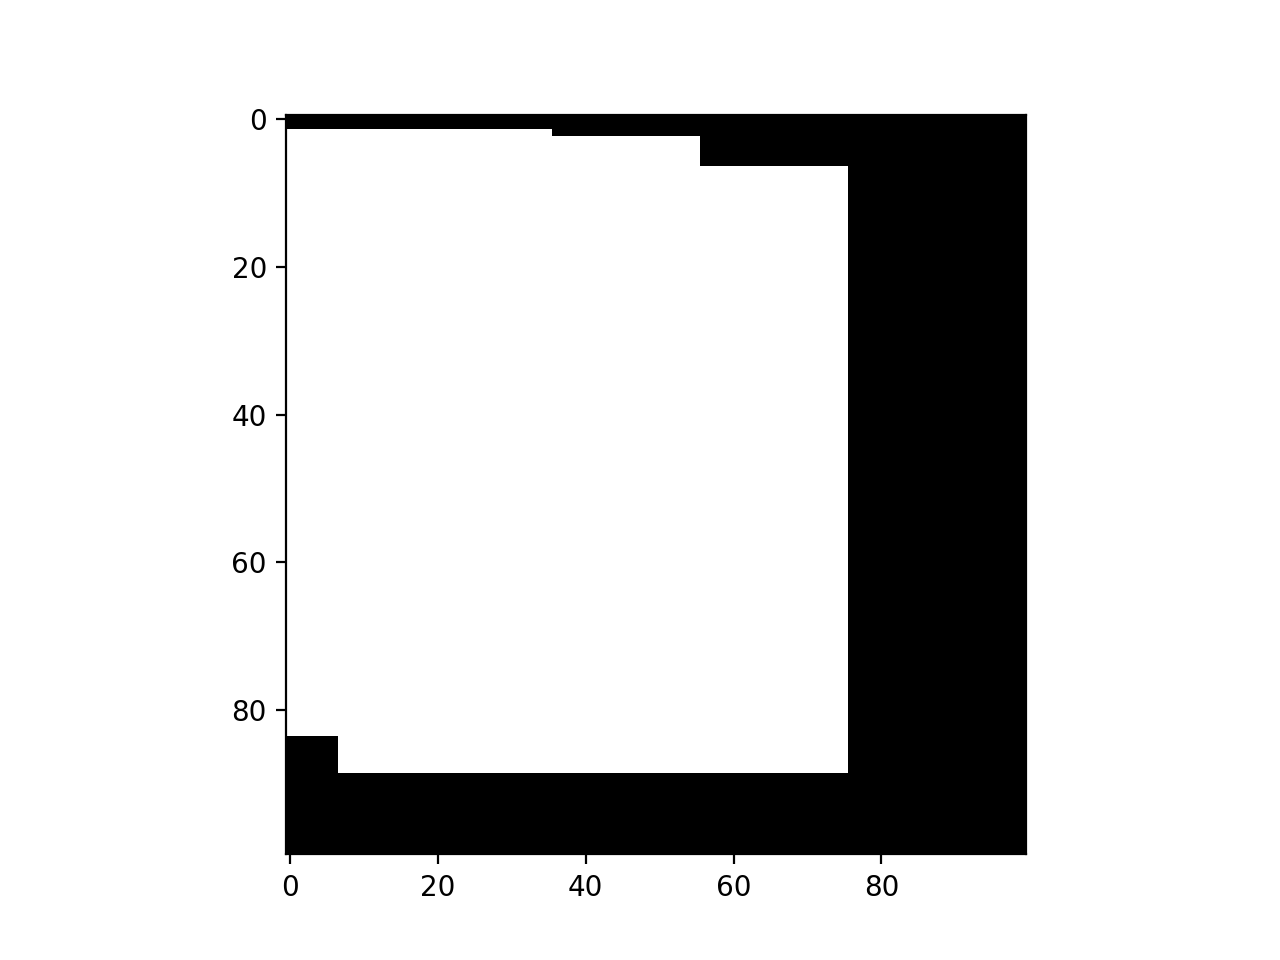

Layer: {'Face', 'Hand', 'Eye', 'Head', 'Mouth', 'Beard', 'Leg', 'Ear', 'Nose', 'Hair', 'Arm'}


<IPython.core.display.Javascript object>


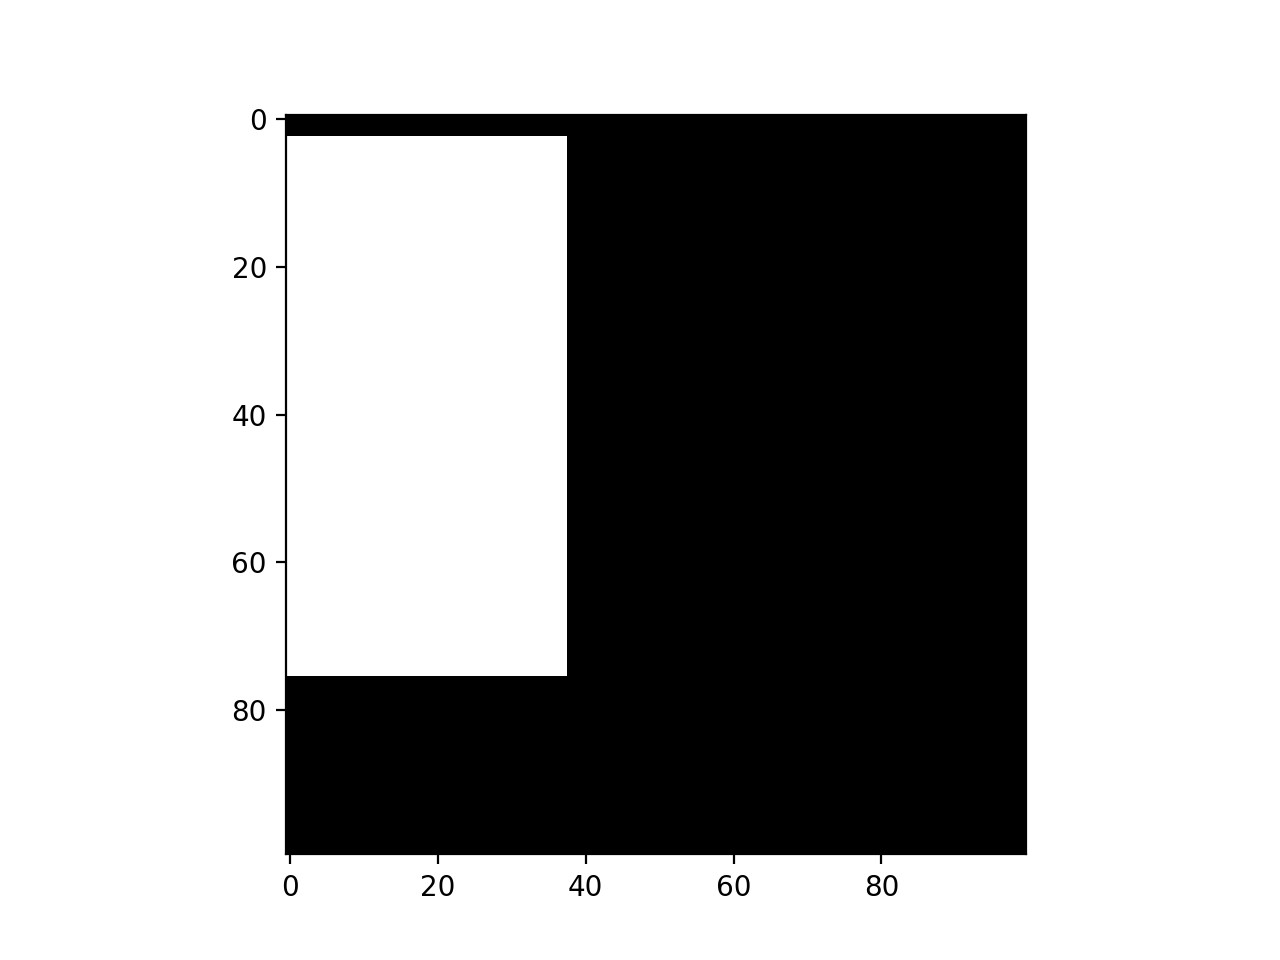

In [8]:
img_mask = image_manager.files[5].reshape([100, 100, NUM_BYTES_FOR_MASK])
folder_path = os.path.join(image_manager.folder_path, '0')
img = cv2.imread(os.path.join(folder_path, os.listdir(folder_path)[5]))
img = cv2.resize(img, (100,100))

plt.figure()
plt.imshow(img)
plt.show()

plt.figure()
print('Layer: Text')
plt.imshow(img_mask[:,:,0], origin="upper", cmap="gray")
plt.show()
        
for i in range(1,NUM_BYTES_FOR_MASK):
    if np.count_nonzero(img_mask[:,:,i])>0:
        print('Layer:',clustered_classes[i-1])
        fig = plt.figure()
        plt.imshow(img_mask[:,:,i], origin="upper", cmap="gray")
        plt.show()

In [8]:
from torch import nn

# BETA VARIATIONAL AUTOENCODER

In [23]:
# Parameters

tf.reset_default_graph()

learning_rate = 1e-4
num_steps = 15
batch_size = 16
# Network Parameters
NUM_BYTES_FOR_MASK = 5+1
image_dim = 100*100*NUM_BYTES_FOR_MASK # images are 100x100 pixels
hidden_dim1 = 1024
hidden_dim2 = 256
latent_dim = 64
n_samples = image_manager.files.shape[0]
beta = 4
# A custom initialization (see Xavier Glorot init)
def glorot_init(shape):
    return tf.random_normal(shape=shape, stddev=1. / tf.sqrt(shape[0] / 2.))

In [24]:
# Variables
weights = {
    'encoder_h1': tf.Variable(glorot_init([image_dim, hidden_dim1])),
    'encoder_h2': tf.Variable(glorot_init([hidden_dim1, hidden_dim2])),
    'z_mean': tf.Variable(glorot_init([hidden_dim2, latent_dim])),
    'z_std': tf.Variable(glorot_init([hidden_dim2, latent_dim])),
    'decoder_h1': tf.Variable(glorot_init([latent_dim, hidden_dim2])),
    'decoder_h2': tf.Variable(glorot_init([hidden_dim2, hidden_dim1])),
    'decoder_out': tf.Variable(glorot_init([hidden_dim1, image_dim]))
}
biases = {
    'encoder_b1': tf.Variable(glorot_init([hidden_dim1])),
    'encoder_b2': tf.Variable(glorot_init([hidden_dim2])),
    'z_mean': tf.Variable(glorot_init([latent_dim])),
    'z_std': tf.Variable(glorot_init([latent_dim])),
    'decoder_b1': tf.Variable(glorot_init([hidden_dim2])),
    'decoder_b2': tf.Variable(glorot_init([hidden_dim1])),
    'decoder_out': tf.Variable(glorot_init([image_dim]))
}

In [25]:
# Building the encoder
input_image = tf.placeholder(tf.float32, shape=[None, image_dim], name='input')
encoder1 = tf.matmul(input_image, weights['encoder_h1']) + biases['encoder_b1']
encoder1 = tf.nn.leaky_relu(encoder1)
# encoder1 = tf.nn.dropout(encoder1, 0.5)
encoder2 = tf.matmul(encoder1, weights['encoder_h2']) + biases['encoder_b2']
encoder = tf.nn.leaky_relu(encoder2)
# encoder2 = tf.nn.dropout(encoder, 0.5)
z_mean = tf.matmul(encoder, weights['z_mean']) + biases['z_mean']
z_std = tf.matmul(encoder, weights['z_std']) + biases['z_std']

# Sampler: Normal (gaussian) random distribution
eps = tf.random_normal(tf.shape(z_std), dtype=tf.float32, mean=0., stddev=1.0,
                       name='epsilon')
z = z_mean + tf.exp(z_std / 2) * eps

# Building the decoder (with scope to re-use these layers later)
decoder1 = tf.matmul(z, weights['decoder_h1']) + biases['decoder_b1']
decoder1 = tf.nn.leaky_relu(decoder1)
# decoder1 = tf.nn.dropout(decoder1, 0.5)
decoder2 = tf.matmul(decoder1, weights['decoder_h2']) + biases['decoder_b2']
decoder2 = tf.nn.leaky_relu(decoder2)
# decoder2 = tf.nn.dropout(decoder2, 0.5)
decoder = tf.matmul(decoder2, weights['decoder_out']) + biases['decoder_out']
decoder = tf.nn.sigmoid(decoder, name='decoder')

In [26]:
# Define VAE Loss
def vae_loss(x_reconstructed, x_true):
    # Reconstruction loss
#     x_reconstructed = tf.clip_by_value(x_reconstructed, 1e-7, 1 - 1e-7)
    encode_decode_loss = x_true * tf.log(1e-7 + x_reconstructed) \
                         + (1 - x_true) * tf.log(1e-7 + 1 - x_reconstructed)
    
    encode_decode_loss = -tf.reduce_sum(encode_decode_loss, 1)
    # KL Divergence loss
    kl_div_loss = 1 + z_std - tf.square(z_mean) - tf.exp(z_std)
    kl_div_loss = -beta * 0.5 * tf.reduce_sum(kl_div_loss, 1)
    return tf.reduce_mean(encode_decode_loss + kl_div_loss)

loss_op = vae_loss(decoder, input_image)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train_op = optimizer.minimize(loss_op)


# TEST GENERATED IMAGES

In [27]:
def image_test_and_plot(image_manager, sess):
    dim_ = 100
    n = 4
    canvas_orig = np.empty((dim_ * n, dim_ * n, NUM_BYTES_FOR_MASK))
    canvas_recon = np.empty((dim_ * n, dim_ * n, NUM_BYTES_FOR_MASK))
    for i in range(n):
        # Image test set
        batch_x = image_manager.next_batch(n)
        batch_x = batch_x[:, :, :, :NUM_BYTES_FOR_MASK]
        batch_x = batch_x.reshape(batch_x.shape[0], -1).astype(np.float16)
        # Encode and decode the digit image
        output = tf.get_default_graph().get_tensor_by_name("decoder:0")
        ip_img= tf.get_default_graph().get_tensor_by_name("input:0")
        g = sess.run(output, feed_dict={ip_img: batch_x})
#         print(g)
        # Display original images
        for j in range(n):
    #         print (batch_x[j])
            # Draw the generated digits
            canvas_orig[i * dim_:(i + 1) * dim_, j * dim_:
                        (j + 1) * dim_,:] = batch_x[j].reshape([dim_, dim_, NUM_BYTES_FOR_MASK])

    #     print (np.max(g[0]))
        # Display reconstructed images
        for j in range(n):
            # Draw the generated digits
            canvas_recon[i * dim_:(i + 1) * dim_, j * dim_:
                         (j + 1) * dim_,:] = g[j].reshape([dim_, dim_, NUM_BYTES_FOR_MASK])
    print(np.linalg.norm(canvas_orig - canvas_recon)/n)

    
    print("Original Images vs Reconstructed Images")  
    for i in range(NUM_BYTES_FOR_MASK):
        print('Layer:',i)
        f, axarr = plt.subplots(1,2)
        axarr[0].imshow(canvas_orig[:,:,i], origin="upper", cmap="gray")
        axarr[1].imshow(canvas_recon[:,:,i], origin="upper", cmap="gray")
        plt.show()
    


# RUN MODEL

# SET GPU List

In [28]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0,1,2,3'

<IPython.core.display.Javascript object>


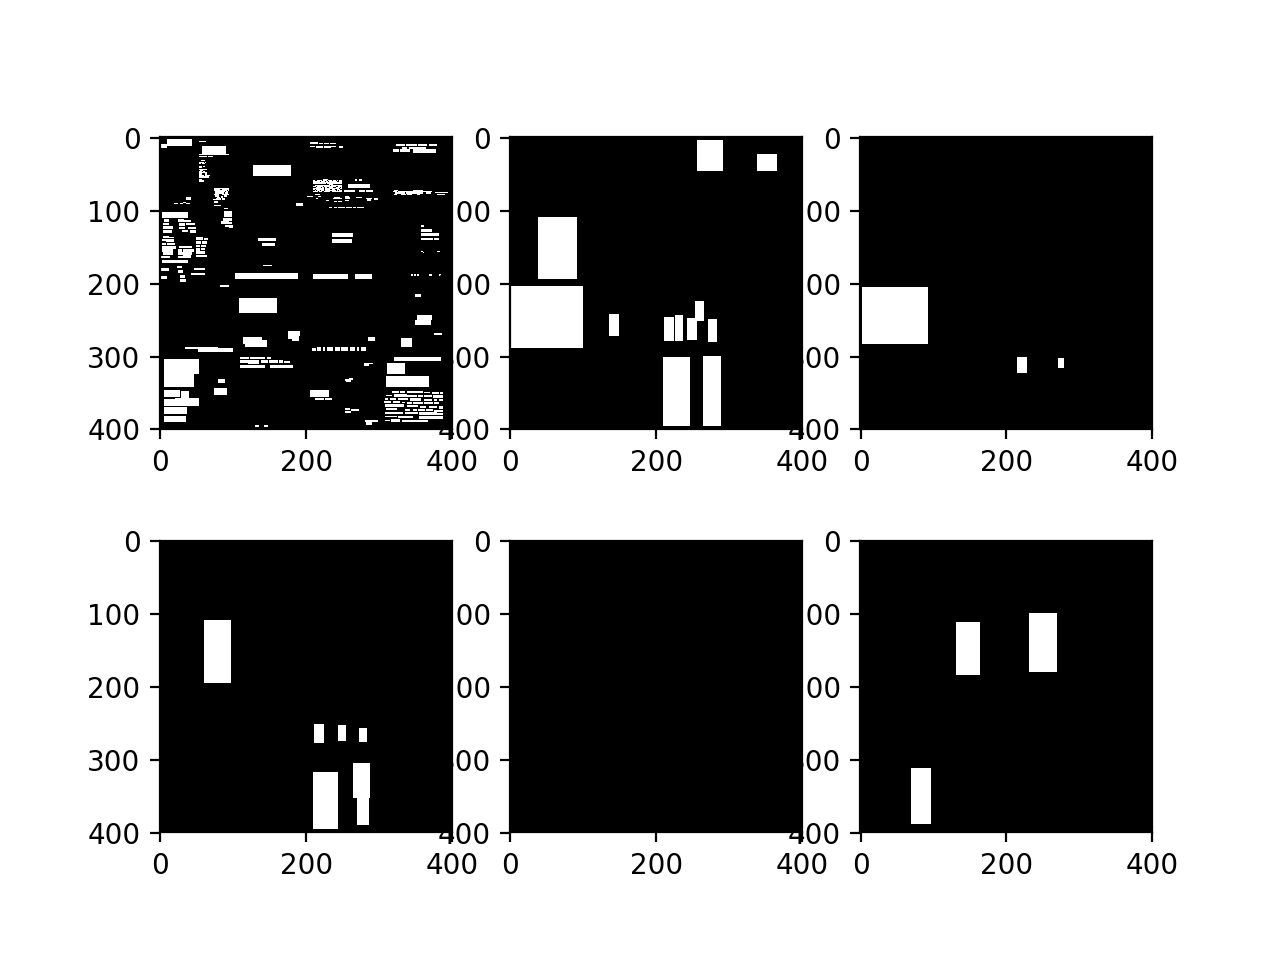

In [29]:
import math
test_images = test_image_manager.next_batch(16)[:, :, :, :NUM_BYTES_FOR_MASK]
test_images = test_images.reshape(test_images.shape[0], -1).astype(np.float16)
n = 4
dim_ = 100
canvas_recon = np.zeros((dim_ * n, dim_ * n, NUM_BYTES_FOR_MASK))
for j in range(n*n):
    # Draw the generated digits 
    x = j//n
    y = j%n
#         print(test_images[j].reshape([100, 100, NUM_BYTES_FOR_MASK]).shape)
#         print(test_images[j].shape)
    canvas_recon[y * 100:(y + 1) * 100, x * 100:
                 (x + 1) * 100,:] = test_images[j].reshape([100, 100, NUM_BYTES_FOR_MASK])
f, axarr = plt.subplots(2,3)

for i in range(NUM_BYTES_FOR_MASK):
    axarr[i//3][i%3].imshow(canvas_recon[:,:,i], origin="upper", cmap="gray")
plt.show()

<IPython.core.display.Javascript object>


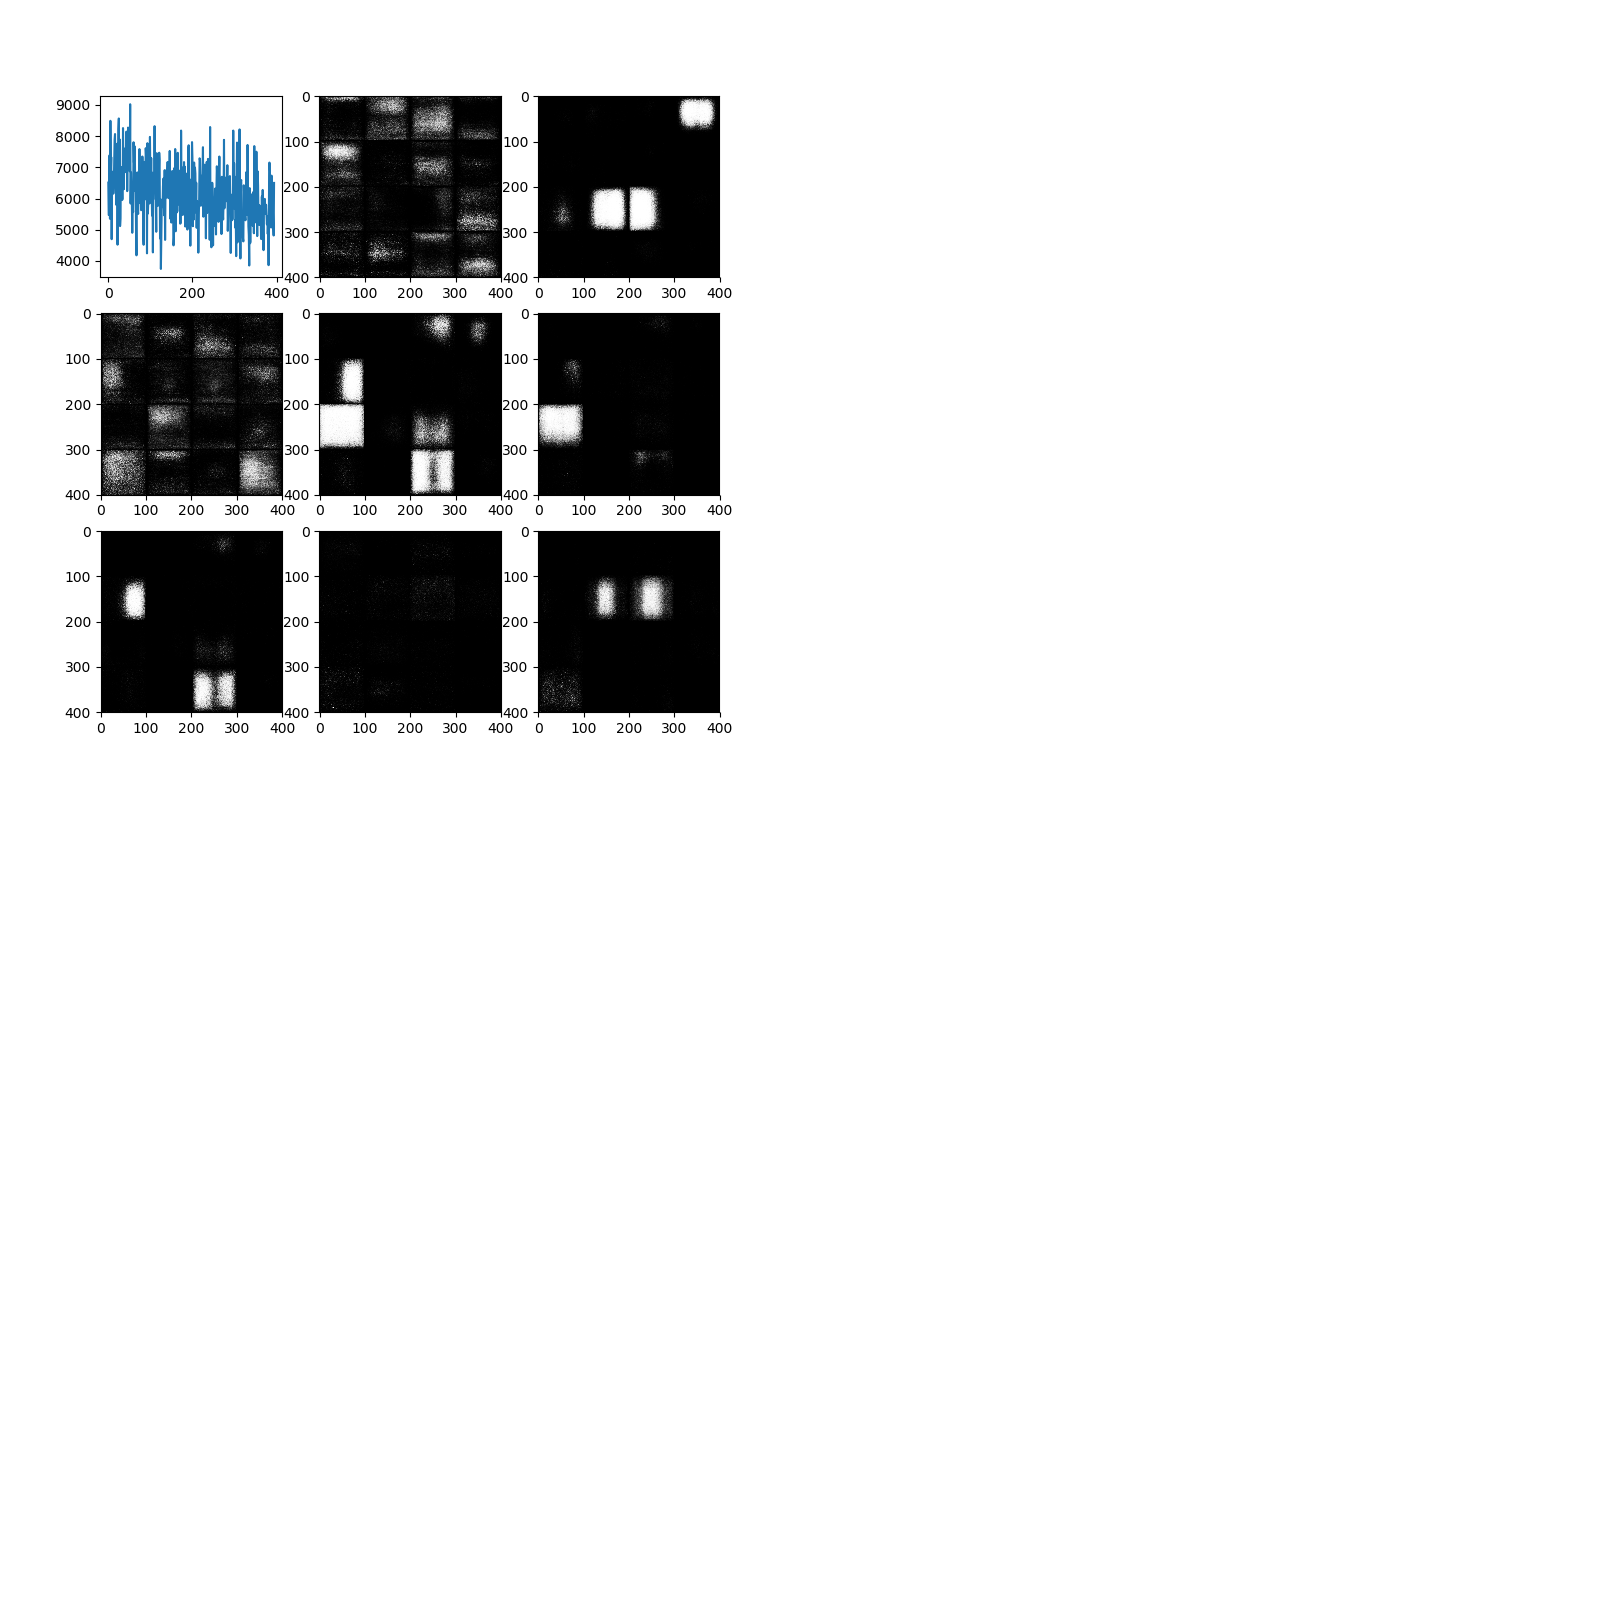

A Jupyter Widget

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.
IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.
IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.
IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.
IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit

In [ ]:
%%time
%matplotlib notebook
# Start Training
# Start a new TF session
# Initialize the variables (i.e. assign their default value)
init = tf.global_variables_initializer()
batch_loss_plot = []
test_loss_plot = []
with tf.Session() as sess:


    # Run the initializer
    sess.run(init)
    
    saver = tf.train.Saver()

    fig,ax = plt.subplots(3,3,figsize=(8,8))
#     plt.ion()
    
    for k in range(NUM_BYTES_FOR_MASK):
        ax[(k+3)//3][(k+3)%3].clear()
        ax[(k+3)//3][(k+3)%3].imshow(canvas_recon[:,:,k], origin="upper", cmap="gray")
    
#     fig.show()
    fig.canvas.draw()
    # Training
    for i in tqdm_notebook(range(num_steps)):
        # Prepare Data
        # Get the next batch of MNIST data (only images are needed, not labels)
        avg_loss = 0.
        total_batch = n_samples // batch_size
        total_batch = total_batch//5
        
        # Loop over all batches
        for j in range(total_batch):
            batch_x = image_manager.next_batch(batch_size)
            batch_x = batch_x[:, :, :, :NUM_BYTES_FOR_MASK]
            batch_x = batch_x.reshape(batch_x.shape[0], -1).astype(np.float16)
            # Train
            feed_dict = {input_image: batch_x}
            _, l = sess.run([train_op, loss_op], feed_dict=feed_dict)
            avg_loss += l / n_samples * batch_size
            batch_loss_plot.append(l)
            ax[0][0].clear()
            ax[0][0].plot(batch_loss_plot[-total_batch:])
            if (j%(total_batch//5))==0:
                g = decoder.eval(feed_dict={input_image: batch_x})
                for k in range(16):
                    # Draw the generated digits 
                    x = k//4
                    y = k%4
                    canvas_recon[y * 100:(y + 1) * 100, x * 100:
                                 (x + 1) * 100,:] = g[k].reshape([100, 100, NUM_BYTES_FOR_MASK])
                for k in range(2):
                    ax[(k+1)//3][(k+1)%3].clear()
                    ax[(k+1)//3][(k+1)%3].imshow(canvas_recon[:,:,k], origin="upper", cmap="gray")
            fig.canvas.draw()
        
        validation_error = loss_op.eval(feed_dict={input_image: test_images})
        
        g = decoder.eval(feed_dict={input_image: test_images})
        for j in range(16):
            # Draw the generated digits 
            x = j//4
            y = j%4
            canvas_recon[y * 100:(y + 1) * 100, x * 100:
                         (x + 1) * 100,:] = g[j].reshape([100, 100, NUM_BYTES_FOR_MASK])
        for k in range(NUM_BYTES_FOR_MASK):
            ax[(k+3)//3][(k+3)%3].clear()
            ax[(k+3)//3][(k+3)%3].imshow(canvas_recon[:,:,k], origin="upper", cmap="gray")
        fig.canvas.draw()
    
        test_loss_plot.append(validation_error)
    model_name = os.path.join(OUT_TF_DATA,'models')+'/'+'_'.join(['vae',str(hidden_dim1),str(hidden_dim2),str(latent_dim),'sigmoid','adam'])+'/model.ckpt'
    save_path = saver.save(sess, model_name)
    
    export_dir = os.path.join(OUT_TF_DATA,'models')+'/'+'_'.join(['vae',str(hidden_dim1),str(hidden_dim2),str(latent_dim),'sigmoid','adam'])
    inputs = {'input': input_image}
    outputs = {'output': decoder}
    print('Saved model at:', save_path)

    image_test_and_plot(image_manager, sess)
    print(test_loss_plot)
    
    p = plt.figure()
    plt.plot(test_loss_plot, label='validation')
    plt.plot(batch_loss_plot, label='minibatch-acc')
    plt.legend()
    plt.show()

## Restore session from saved model

INFO:tensorflow:Restoring parameters from /gpfs/scratch/asamanta/models/vae_1024_256_64_sigmoid_adam/model.ckpt
26.5890908557
Original Images vs Reconstructed Images
Layer: 0


<IPython.core.display.Javascript object>


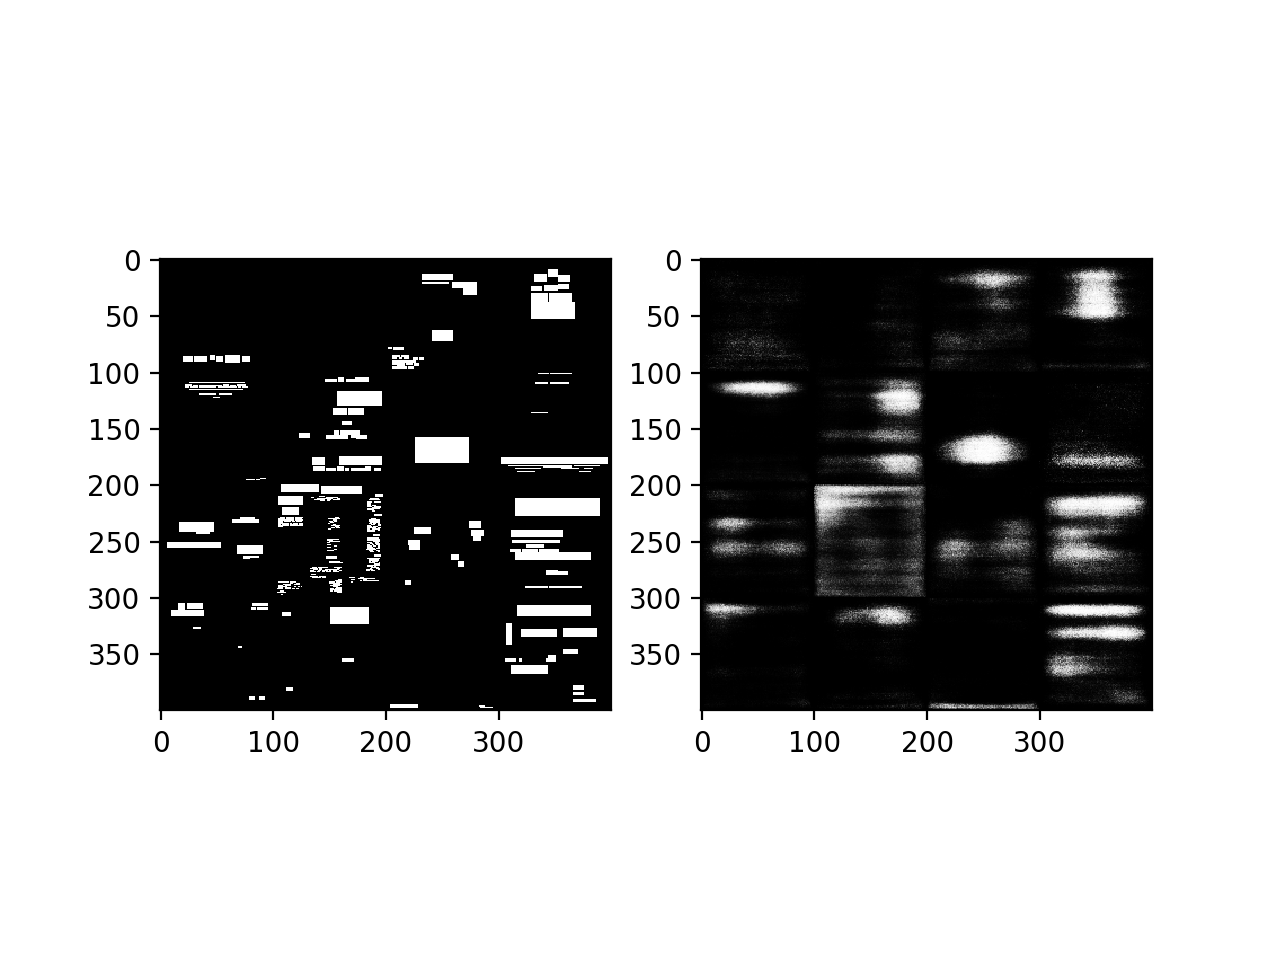

Layer: 1


<IPython.core.display.Javascript object>


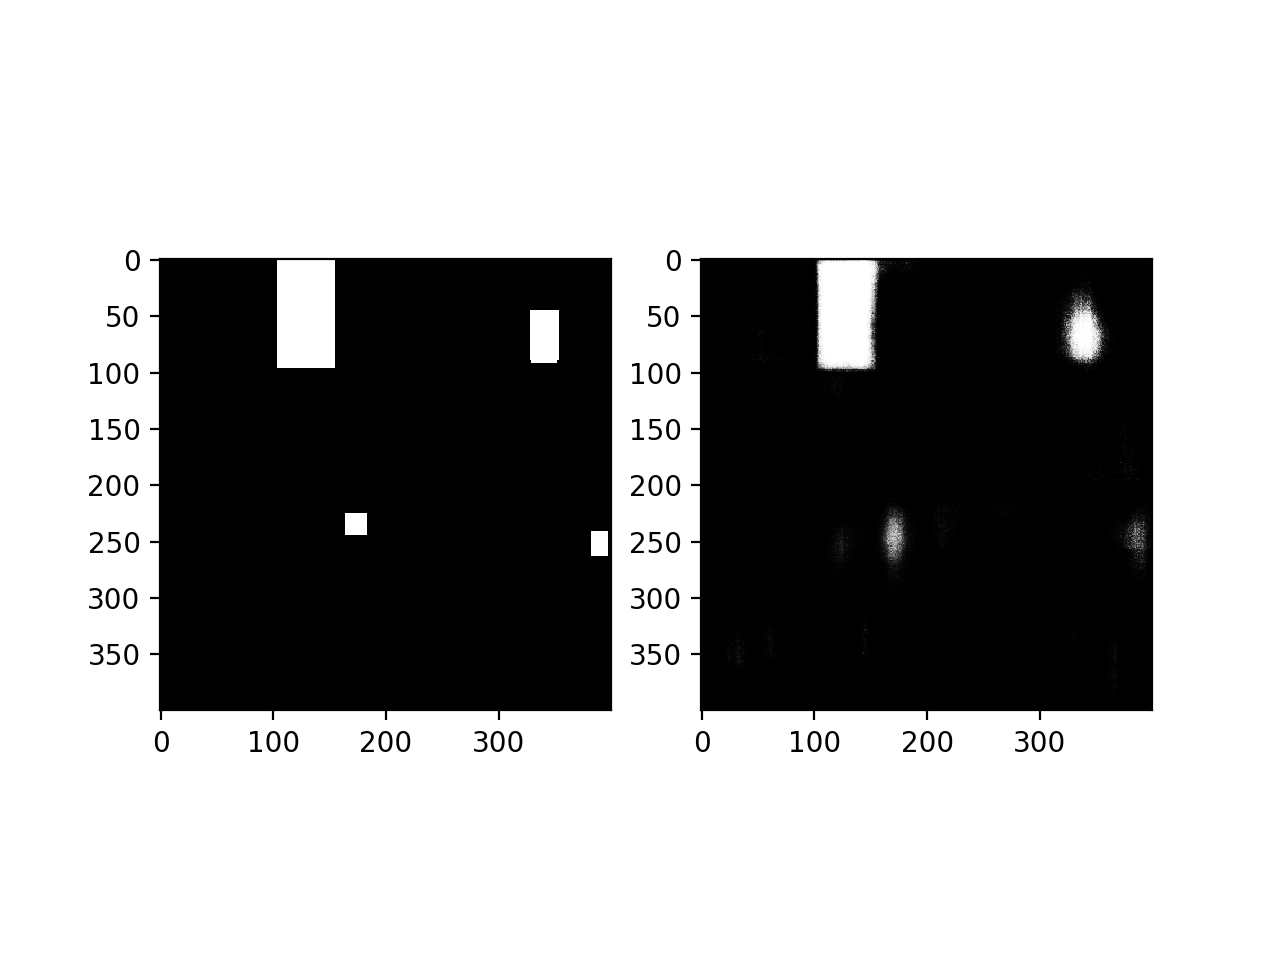

Layer: 2


<IPython.core.display.Javascript object>


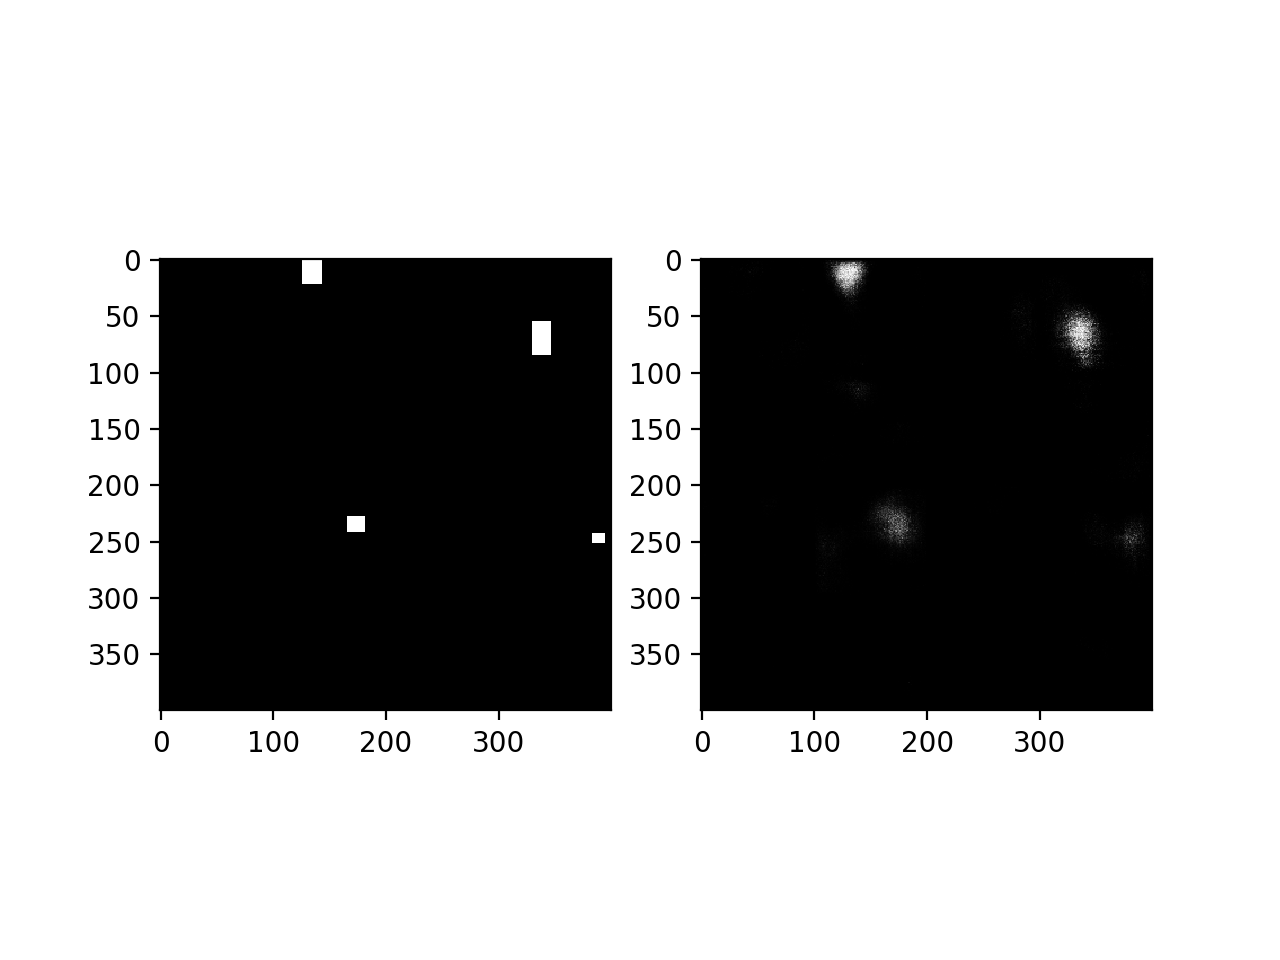

Layer: 3


<IPython.core.display.Javascript object>


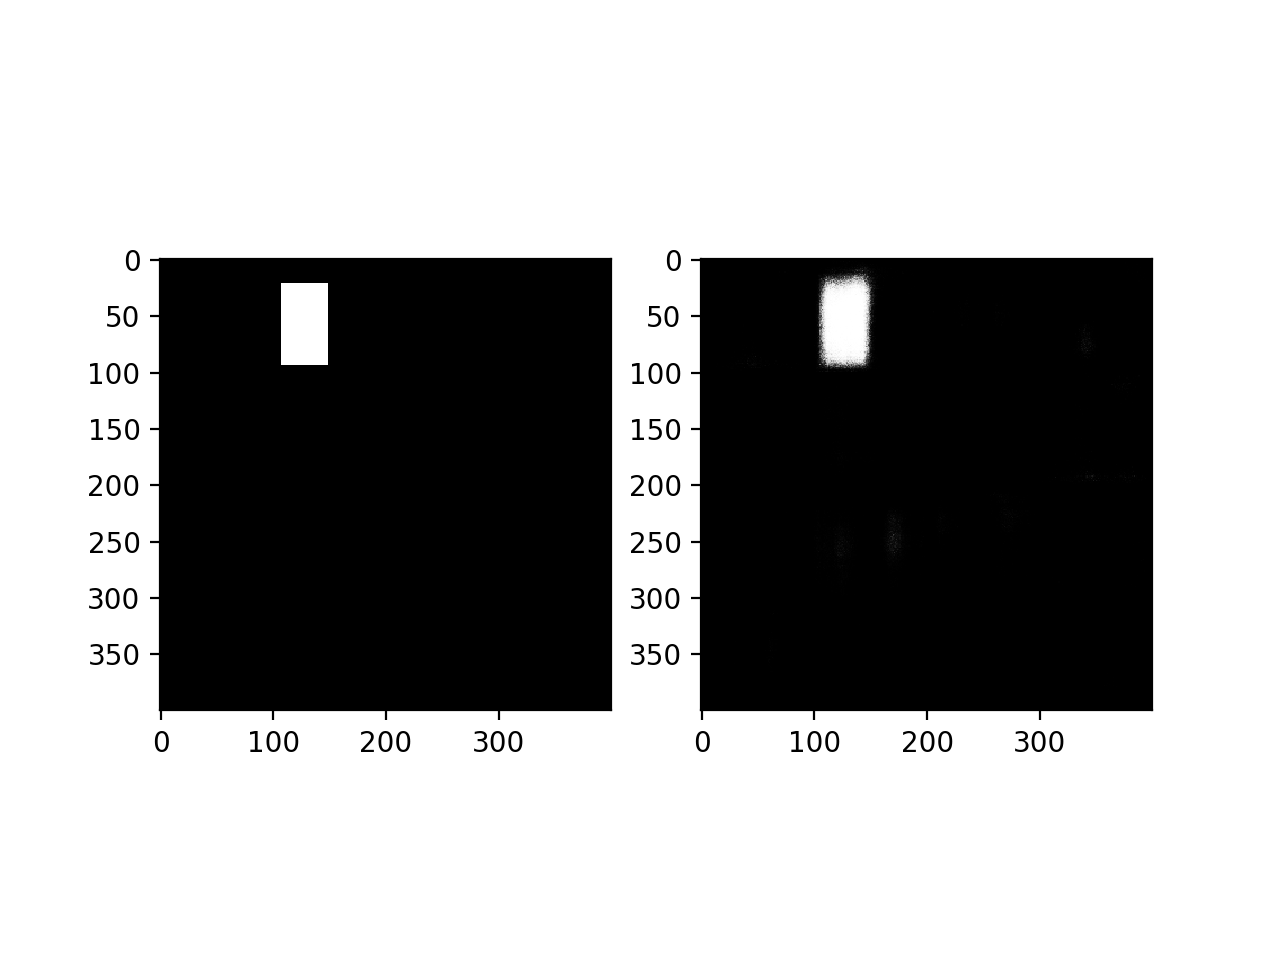

Layer: 4


<IPython.core.display.Javascript object>


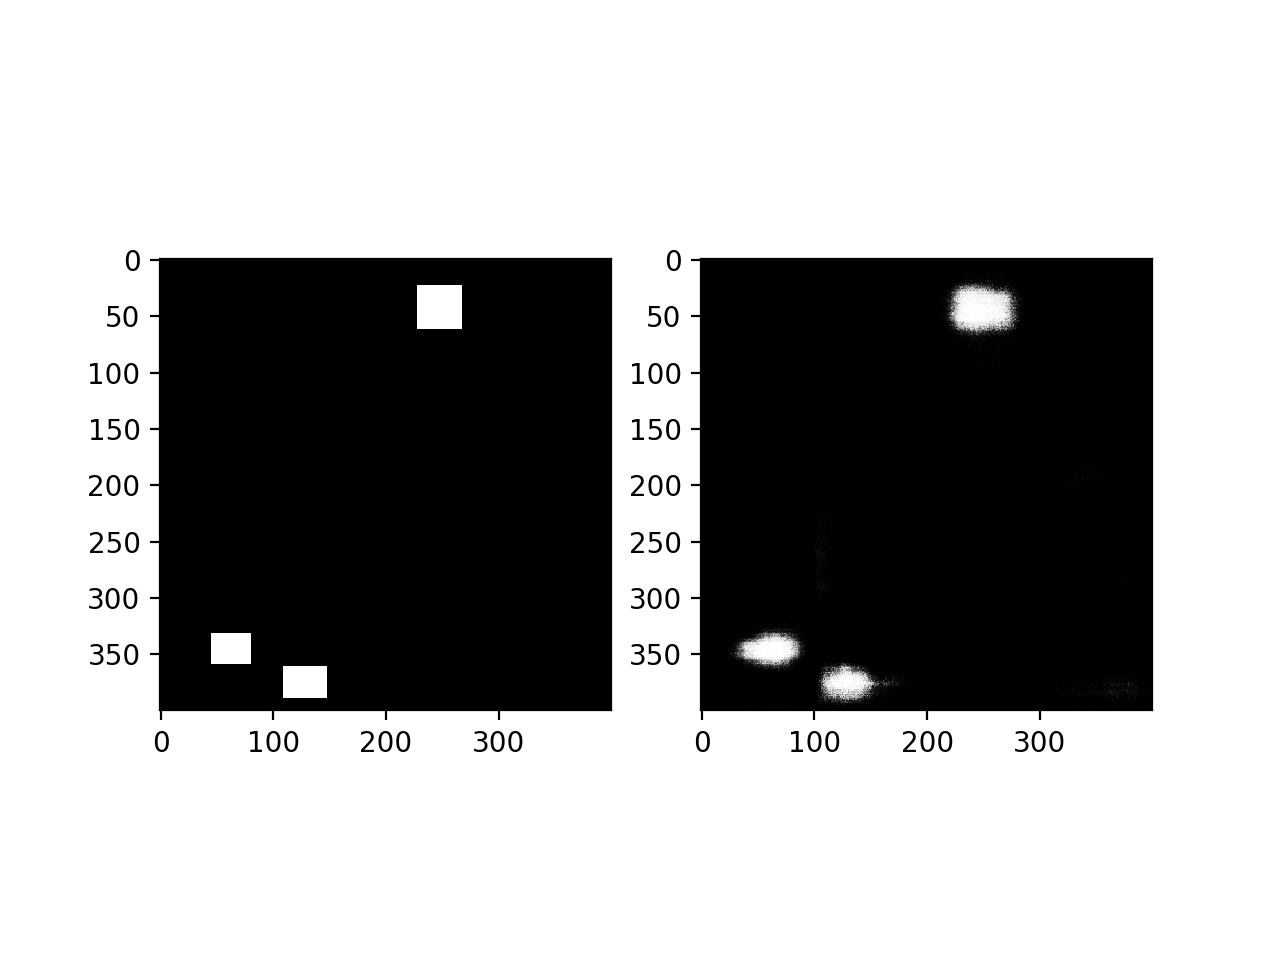

Layer: 5


<IPython.core.display.Javascript object>


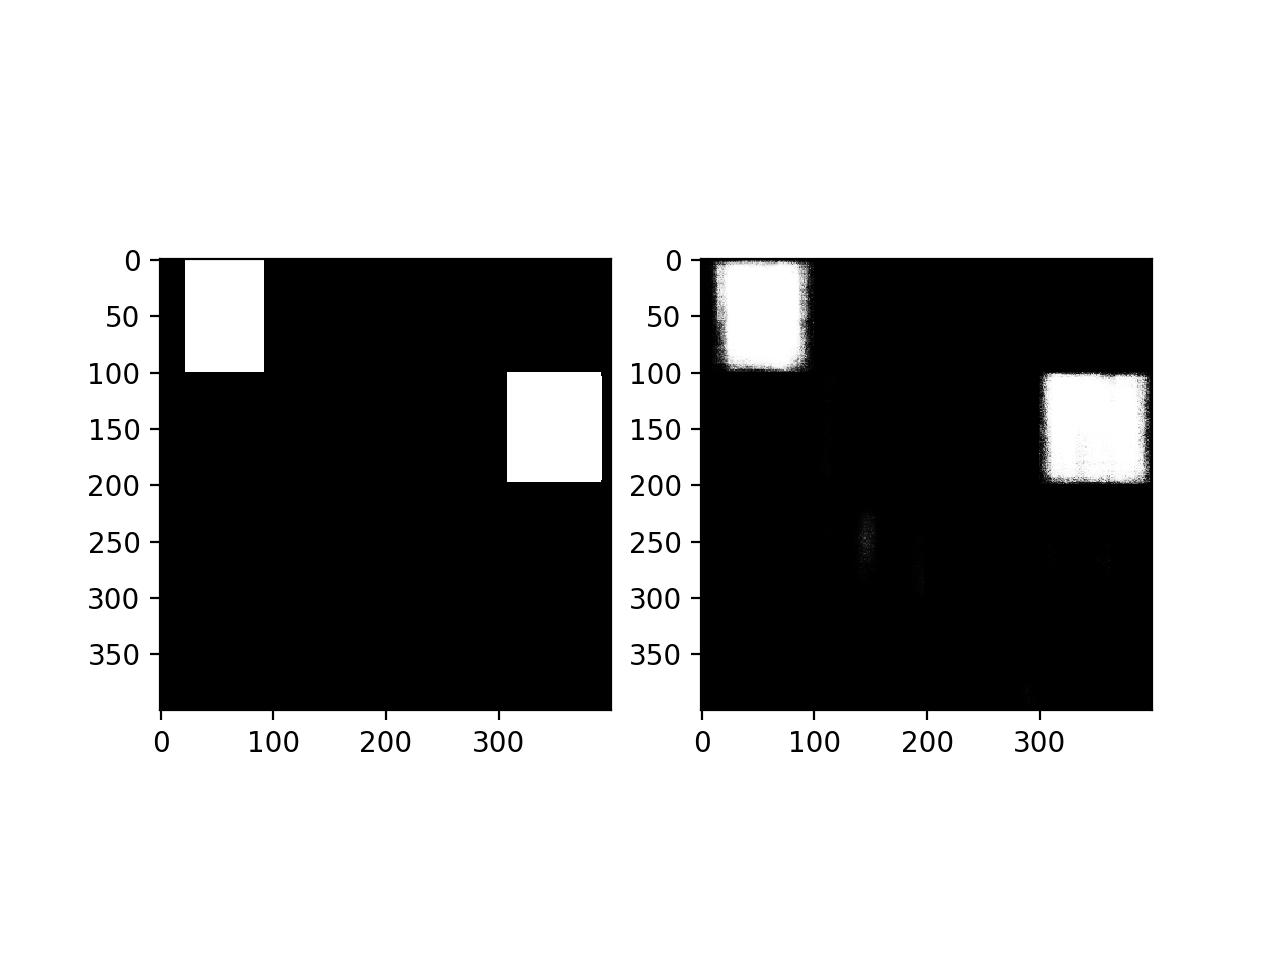

In [13]:
MODEL_PATH = '/gpfs/scratch/asamanta/models/vae_1024_256_64_sigmoid_adam/'
tf.reset_default_graph()
with tf.Session() as sess:
  # Initialize v1 since the saver will not.
#   v1.initializer.run()
    saver = tf.train.import_meta_graph(MODEL_PATH+'model.ckpt.meta')
    saver.restore(sess, tf.train.latest_checkpoint(MODEL_PATH))
    image_test_and_plot(test_image_manager, sess)

# TESTING

In [14]:
from matplotlib.widgets  import RectangleSelector
rect_colors = {'2':'#00F300', '3':'#0000ff', '4':'#0f0201', '1': '#f00165'}
layers = {'2':2, '3':1, '4':3, '1':0}
layer_names = {'2':'Human', '3':'Body part', '4':'Vehicle', '1':'Text'}

<IPython.core.display.Javascript object>


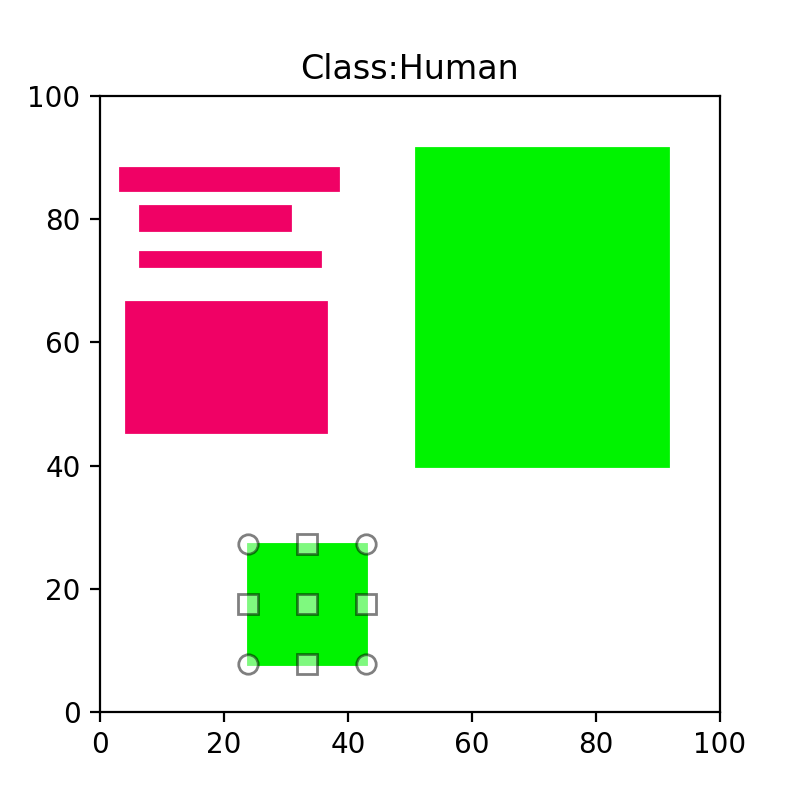

In [15]:
%matplotlib notebook
xdata = np.linspace(0,100, num=100)
ydata = np.linspace(0,100, num=100)

fig, ax = plt.subplots(figsize=(4,4))
ax.set_ylim(0,100)
ax.set_xlim(0,100)
# line, = ax.plot(xdata, ydata)
event_list = []
key_list = []

def toggle_selector(event):
    print(' Key pressed.')
    if event.key in ['Q', 'q'] and toggle_selector.RS.active:
        print(' RectangleSelector deactivated.')
        toggle_selector.RS.set_active(False)
    if event.key in ['R', 'r']:
        print(' RectangleSelector reset.')
        ax.cla()
        ax.set_ylim(0,100)
        ax.set_xlim(0,100)
    if event.key in rect_colors.keys():
        ax.set_title('Class:'+layer_names[event.key])
        print('Class', event.key)
        key_list.append(event.key)
        

def line_select_callback(eclick, erelease):
    x1, y1 = eclick.xdata, eclick.ydata
    x2, y2 = erelease.xdata, erelease.ydata
    try:
        color = rect_colors[key_list[-1]]
    except:
        color = rect_colors['1']
    rect = plt.Rectangle((min(x1,x2),min(y1,y2)), np.abs(x1-x2), np.abs(y1-y2), color=color)
    event_list.append((key_list[-1], int(min(x1,x2)),int(min(y1,y2)), int(np.abs(x1-x2)), int(np.abs(y1-y2))))
    ax.add_patch(rect)


rs = RectangleSelector(ax, line_select_callback,
                       drawtype='box', useblit=True, button=[1], 
                       minspanx=5, minspany=5, spancoords='pixels', 
                       interactive=True)
plt.connect('key_press_event', toggle_selector)
plt.show()

In [16]:
# %matplotlib inline
test_image = np.zeros((1,100,100,NUM_BYTES_FOR_MASK), dtype=np.uint8)
for key, x, y, dx, dy in event_list:
    test_image[0, 100-y-dy:100-y, x:x+dx,layers[key]] = 1

img_mask = test_image[0]

INFO:tensorflow:Restoring parameters from /gpfs/scratch/asamanta/models/vae_1024_256_64_sigmoid_adam/model.ckpt
float32
38.1182
Original Images vs Reconstructed Images


<IPython.core.display.Javascript object>


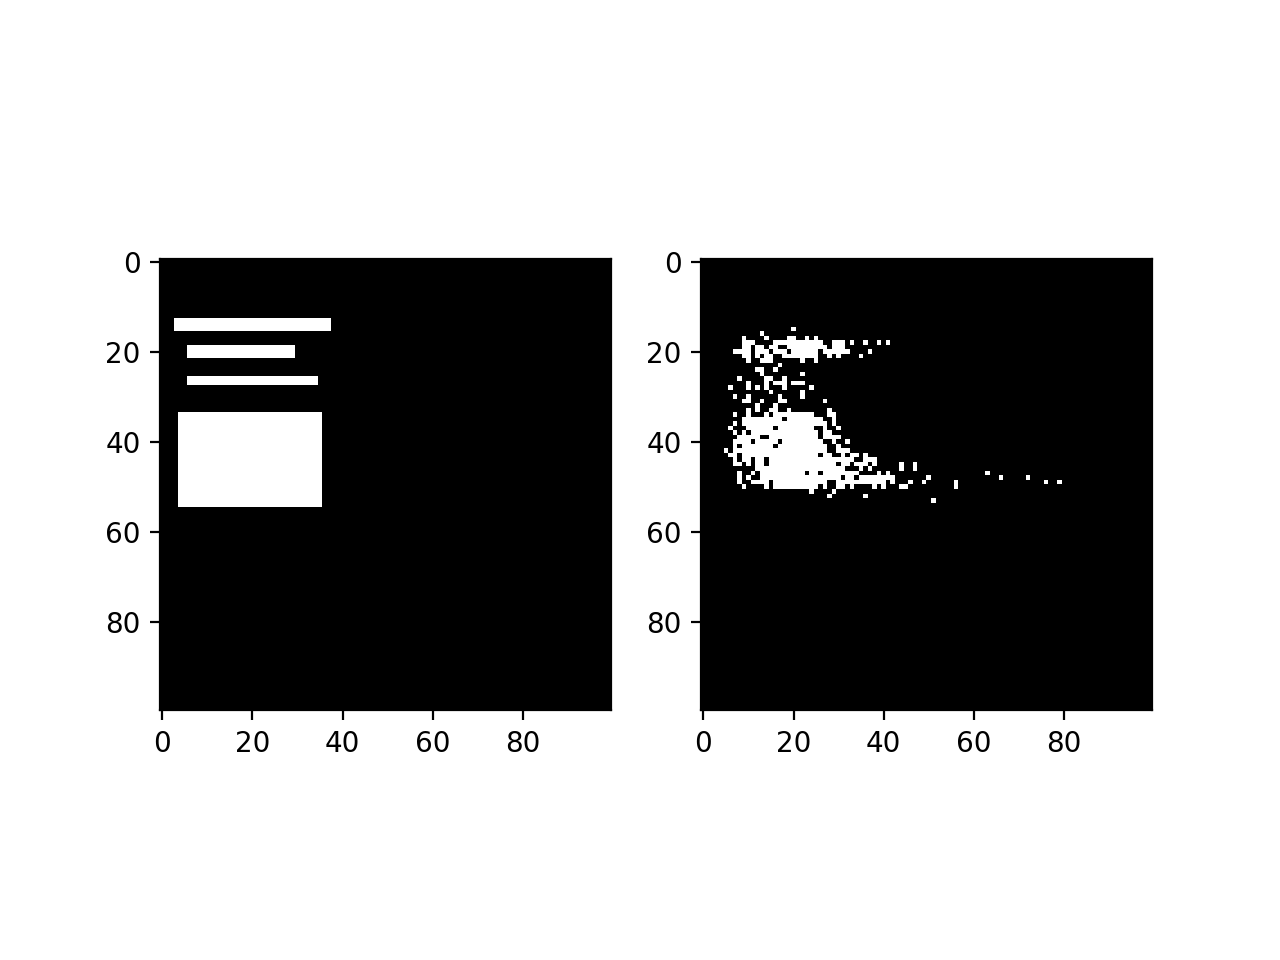

<IPython.core.display.Javascript object>


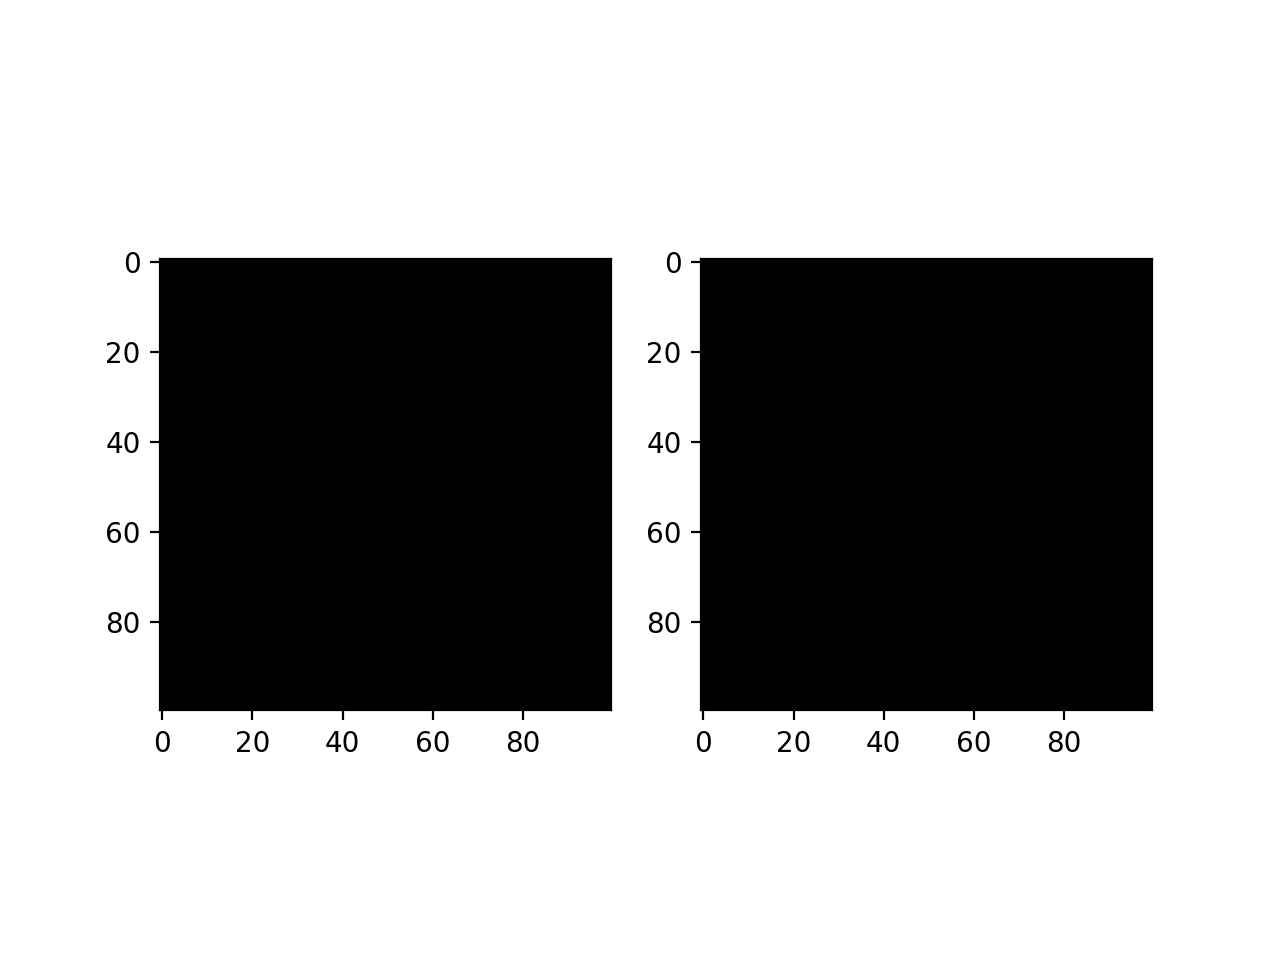

<IPython.core.display.Javascript object>


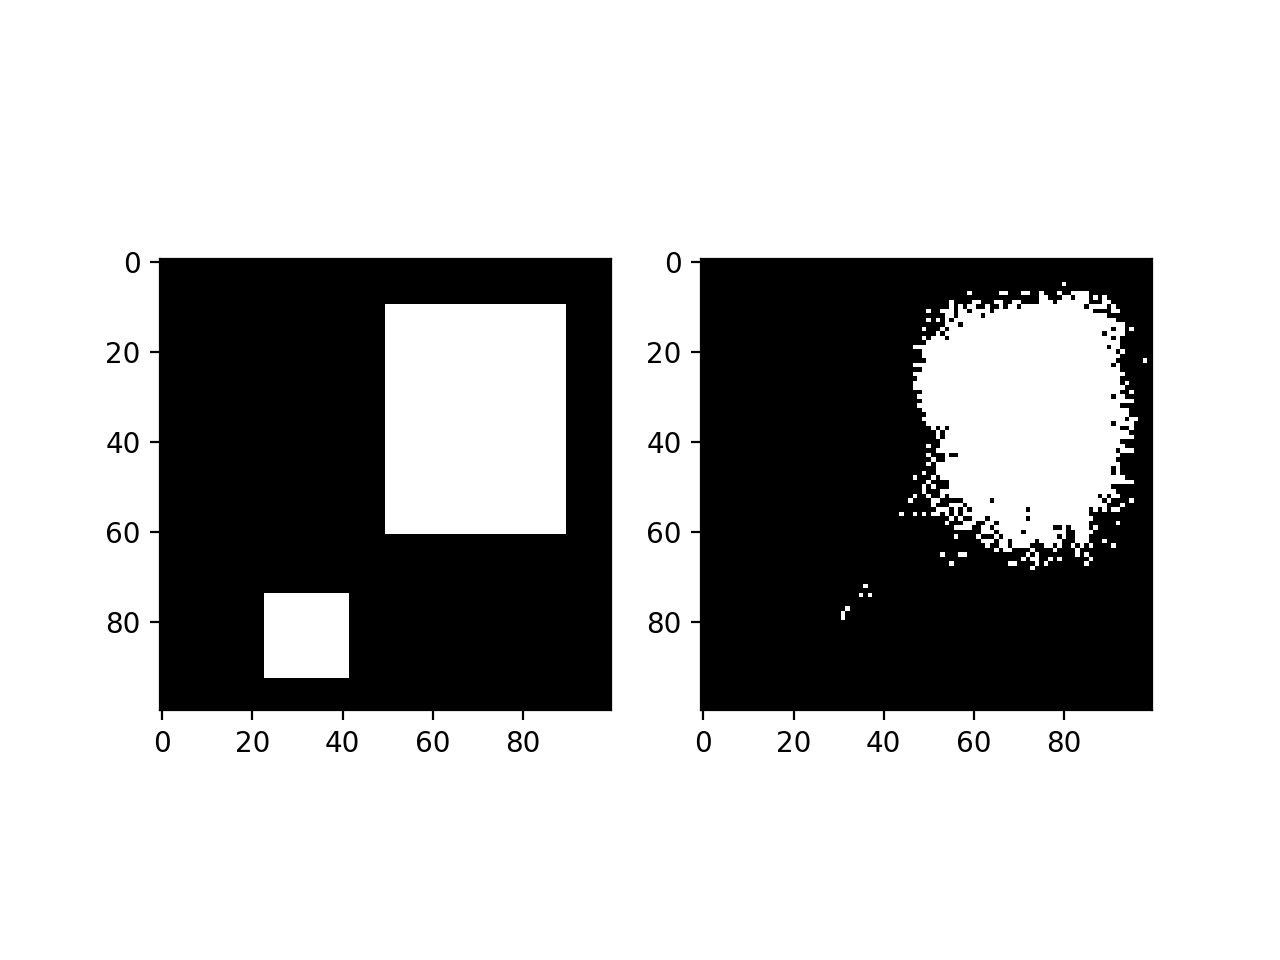

<IPython.core.display.Javascript object>


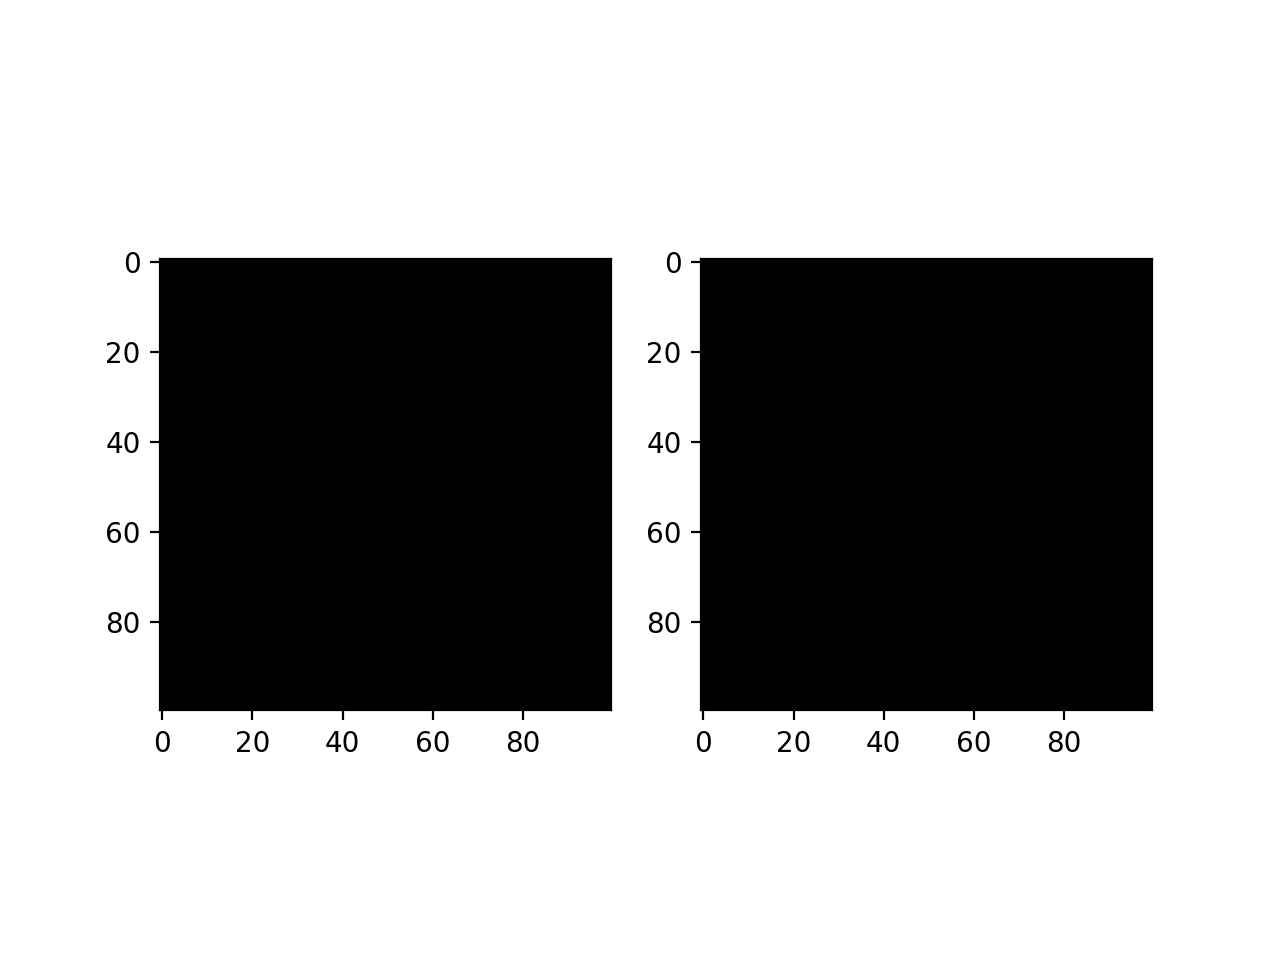

<IPython.core.display.Javascript object>


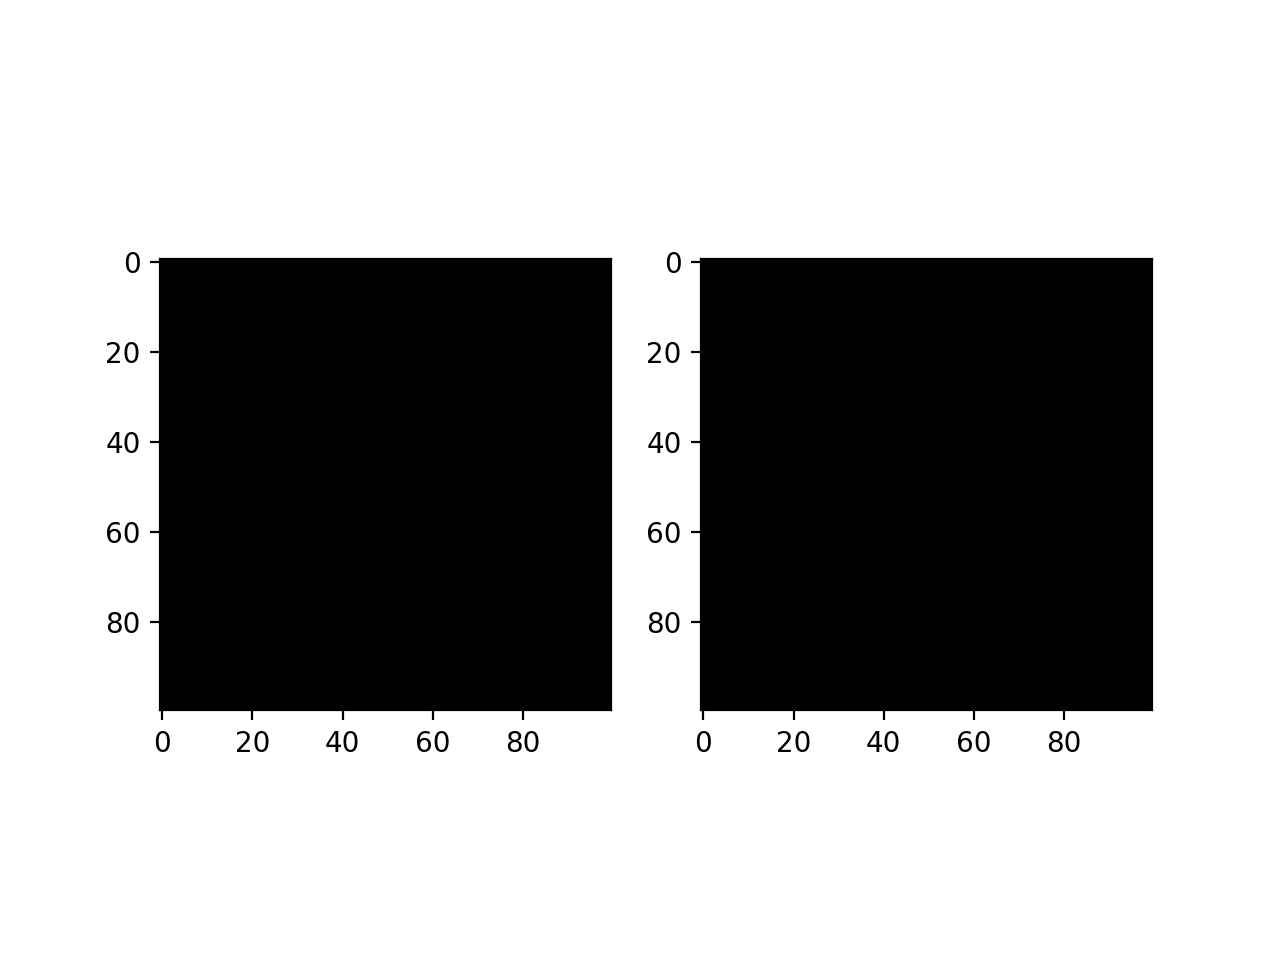

<IPython.core.display.Javascript object>


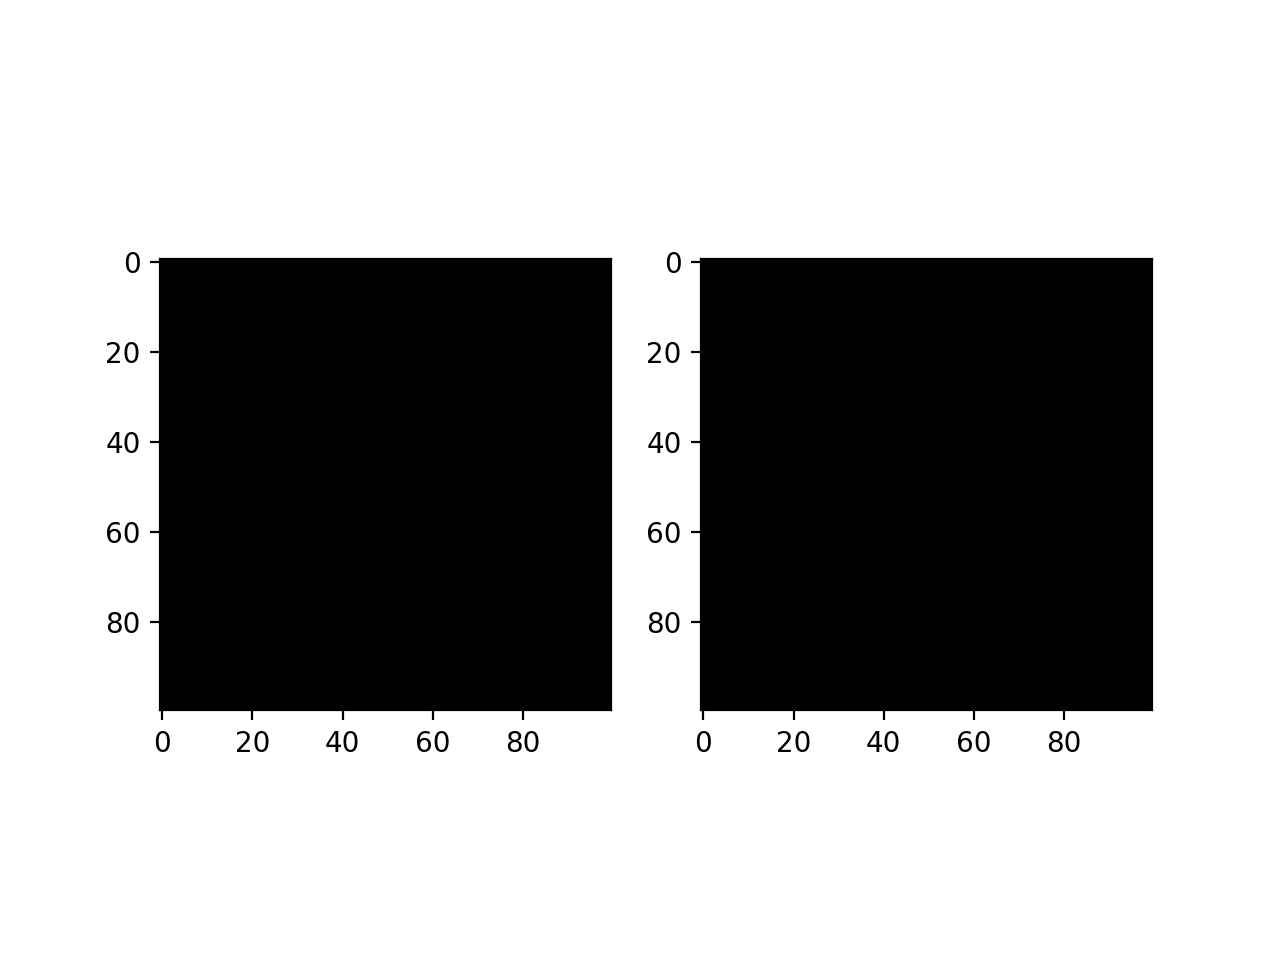

In [22]:
MODEL_PATH = '/gpfs/scratch/asamanta/models/vae_1024_256_64_sigmoid_adam/'
tf.reset_default_graph()
with tf.Session() as sess:
  # Initialize v1 since the saver will not.
#   v1.initializer.run()
    saver = tf.train.import_meta_graph(MODEL_PATH+'model.ckpt.meta')
    saver.restore(sess, tf.train.latest_checkpoint(MODEL_PATH))
    dim_ = 100

    # Image test set
    batch_x = test_image
    batch_x = batch_x.reshape(batch_x.shape[0], -1).astype(np.float32)
    print(batch_x.dtype)
    # Encode and decode the digit image
    output = tf.get_default_graph().get_tensor_by_name("decoder:0")
    ip_img= tf.get_default_graph().get_tensor_by_name("input:0")
    g = sess.run(output, feed_dict={ip_img: batch_x})

    canvas_orig = np.round(batch_x).reshape([dim_, dim_, NUM_BYTES_FOR_MASK])
    canvas_recon = np.round(g).reshape([dim_, dim_, NUM_BYTES_FOR_MASK])
    print(np.linalg.norm(canvas_orig - canvas_recon))

    print("Original Images vs Reconstructed Images")  
    for i in range(NUM_BYTES_FOR_MASK):
        f, axarr = plt.subplots(1,2)
        axarr[0].imshow(canvas_orig[:,:,i], origin="upper", cmap="gray")
        axarr[1].imshow(canvas_recon[:,:,i], origin="upper", cmap="gray")
    plt.show()